<a href="https://colab.research.google.com/github/currencyfxjle/KNAPSACK_GDF_13.0/blob/main/KNAPSACK_GDF_13_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gspread
!pip install gspread-dataframe
!pip install --upgrade oauth2client
!pip install xlsxwriter

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# List files and folders under My Drive
base_path = '/content/drive/My Drive'
for root, dirs, files in os.walk(base_path):
    print(f"Directory: {root}")
    for directory in dirs:
        print(f"  Sub-directory: {directory}")
    for file in files:
        print(f"  File: {file}")

import os

correct_path = '/content/drive/My Drive/Colab Notebooks/GDF - Knapsack/2025 Project Agenda.gsheet'

if os.path.exists(correct_path):
    print("File exists:", correct_path)
else:
    print("File does NOT exist:", correct_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.4 MB/s eta 0:00:00
Mounted at /content/drive
Directory: /content/drive/My Drive
  Sub-directory: Risk Modeling
  Sub-directory: Colab Notebooks
  File: Financial Concepts   Solar Energy Greenday Finance.gdoc
  File: config.zip
  File: 2024 Project Allocation Results (7).gsheet
  File: 2024 Project Allocation Results (6).gsheet
  File: 2024 Project Allocation Results (5).gsheet
  File: 2024 Project Allocation Results (4).gsheet
  File: 2024 Project Allocation Results (3).gsheet
  File: 2024 Project Allocation Results (2).gsheet
  File: 2024 Project Allocation Results (1).gsheet
  File: 2024 Project Allocation Results.gsheet
  File: Estados de Resultados - Victor Lizarraga.gdoc
  File: Ajustes  knapsack Lalo.gsheet
  File: Backup 2025.gsheet
  File: Ruta calculadora.gdoc
  File: KNAPSACK - GDF - Last Version 2.1.ipynb
  File: Knapsack Project.gdoc
  File: Notes.gdoc
  File: Allocation Jan 2025.gsheet
  File: Hubspot - 2025 Fore

**Full Project allocation, no financing stage**

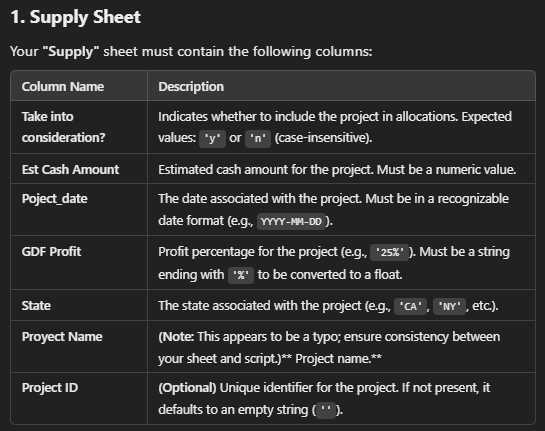

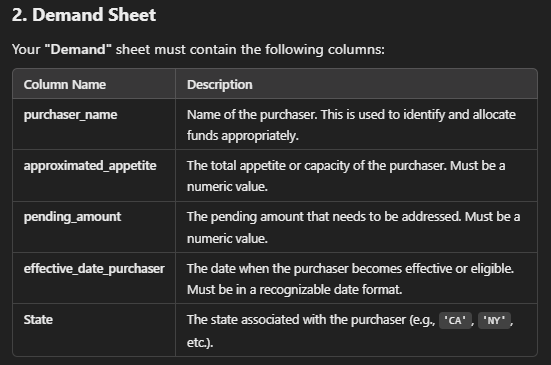

**Full Allocations / No Financing / Prioritizing full projects and improved vocabulary**

In [10]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (e.g., '25%' to 0.25)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna()

    # -------------------------------
    # Sort by GDF Profit DESC,
    # then Est Cash Amount DESC,
    # then Poject_date ASC
    # -------------------------------
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Add additional tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Add category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # Include project state for info
    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Rename 'purchaser_name' to 'Purchaser Name' for consistency
    demand_df = demand_df.rename(columns={'purchaser_name': 'Purchaser Name'})

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['pending_amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna()

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']

    # Add category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # Add priority for state (CA=1, others=2)
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # (Optional) Sort demand initially by appetite desc, then state priority
    demand_df = demand_df.sort_values(
        by=['approximated_appetite', 'State Priority'],
        ascending=[False, True]
    )

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand without Financing
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df):
    """
    Allocates chunks from supply to purchasers in demand.
    Prioritizes GDF Profit (descending) on supply side,
    and CA-first + large appetites on the demand side.

    Only allocates if purchaser's remaining appetite >= chunk cost.
    """
    allocations = []
    total_allocated = 0.0

    # Group supply by Project Name in the sorted order
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for project_name, group in grouped_supply:
        # If the entire project is already allocated, skip
        if group['Fully Allocated'].all():
            continue

        project_total_cost = group['Est Cash Amount'].sum()
        project_chunks = group.to_dict('records')  # Convert group to list of chunk-rows

        can_allocate_project = True
        temp_allocations = []
        temp_demand = demand_df.copy()  # Work on a copy, finalize only if successful

        # -------------------------------------
        # For each chunk in the current project
        # -------------------------------------
        for chunk in project_chunks:
            if chunk['Fully Allocated']:
                continue  # Already allocated

            chunk_cost = chunk['Est Cash Amount']
            allocated = False

            # Sort potential purchasers by: CA first, then large appetite
            # (State Priority asc => CA=1 first, then appetite desc)
            purchasers = temp_demand[temp_demand['remaining_appetite'] >= chunk_cost].sort_values(
                by=['State Priority', 'remaining_appetite'],
                ascending=[True, False]
            ).to_dict('records')

            # -------------------------------------
            # Try each purchaser in sorted order
            # -------------------------------------
            for purchaser in purchasers:
                # Must meet date requirement
                if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                    # This purchaser isn't eligible yet
                    continue

                # Current stats
                p_appetite = purchaser['remaining_appetite']
                p_pending = purchaser['pending_amount']

                # Allocate the full chunk if possible
                new_appetite = p_appetite - chunk_cost
                new_pending = p_pending - chunk_cost

                # Clamp so they never go below zero
                if new_appetite < 0:
                    new_appetite = 0
                if new_pending < 0:
                    new_pending = 0

                # Update the temp purchaser
                purchaser['remaining_appetite'] = new_appetite
                purchaser['pending_amount'] = new_pending

                # Record the allocation
                temp_allocations.append({
                    "Purchaser Name": purchaser['Purchaser Name'],
                    "Purchaser State": purchaser['State'],
                    "Purchaser Date": purchaser['effective_date_purchaser'],  # Use updated date
                    "Purchaser Category": purchaser['Purchaser Category'],
                    "Project ID": chunk.get('Project ID', ''),
                    "Project Name": project_name,
                    "Project Date": chunk['Poject_date'],
                    "Project Category": chunk['Project Category'],
                    "Project State": chunk['Project State'],
                    "GDF Profit": chunk['GDF Profit'],
                    "Allocated Amount": chunk_cost,
                    "Financed Amount": 0.0,  # No financing
                    "Remaining Appetite After": new_appetite,
                    "Original Appetite": purchaser['approximated_appetite']
                })

                # Update the temp_demand DataFrame
                temp_demand.loc[
                    temp_demand['Purchaser Name'] == purchaser['Purchaser Name'],
                    'remaining_appetite'
                ] = new_appetite
                temp_demand.loc[
                    temp_demand['Purchaser Name'] == purchaser['Purchaser Name'],
                    'pending_amount'
                ] = new_pending

                # Mark chunk as allocated
                chunk['Fully Allocated'] = True
                allocated = True
                break  # Move to the next chunk after successful allocation

            # If we failed to allocate this chunk to any purchaser, skip the project
            if not allocated:
                can_allocate_project = False
                break

        # If every chunk is allocated, we finalize the temp updates
        if can_allocate_project:
            allocations.extend(temp_allocations)
            total_allocated += project_total_cost
            demand_df = temp_demand  # Make the changes permanent
            # Mark all chunks in this group as fully allocated
            supply_df.loc[group.index, 'Fully Allocated'] = True

    return total_allocated, allocations, supply_df, demand_df

# ------------------------------------------------
# 4. Main Execution
# ------------------------------------------------
def main():
    # 4.1 Read data
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # 4.2 Run allocation without financing
    total_allocated, allocations, remaining_supply, remaining_demand_df = match_supply_to_demand(
        supply_df,
        demand_df
    )

    # 4.3 Calculate summaries
    original_total_appetite = demand_df['approximated_appetite'].sum()
    remaining_demand = remaining_demand_df['remaining_appetite'].sum()

    original_total_project_value = supply_df['Original Est Cash Amount'].sum()
    remaining_supply_value = remaining_supply[remaining_supply['Fully Allocated'] == False]['Est Cash Amount'].sum()

    # Calculate percentage of allocated supply as a decimal
    percent_allocated_supply = (total_allocated / original_total_project_value) if original_total_project_value > 0 else 0

    # 4.4 Print Results Summary in Desired Format
    print("\nResults Summary:")
    print(f"Total Allocated \t {total_allocated:,.2f}")
    print(f"DEMAND\t SUM")
    print(f"Original Total Appetite\t {original_total_appetite:,.2f}")
    print(f"Remaining Demand\t {remaining_demand:,.2f}")
    print()
    print(f"% of Allocated Supply\t{percent_allocated_supply:.2f}")
    print(f"SUPPLY\t SUM")
    print(f"Original Total Project Value\t {original_total_project_value:,.2f}")
    print(f"Remaining Supply\t {remaining_supply_value:,.2f}")

    # 4.5 Create Supply Summary
    supply_summary = supply_df.groupby('Proyect Name').agg(
        Total_Chunks_Before=('Est Cash Amount', 'count'),
        Total_Chunks_After=('Fully Allocated', lambda x: x.sum()),
        Total_Project_Value=('Est Cash Amount', 'sum'),
        Latest_Project_Date=('Poject_date', 'max'),           # New Column
        Max_Est_Cash_Amount=('Est Cash Amount', 'max'),       # New Column
        GDF_Profit=('GDF Profit', 'max')                      # New Column
    ).reset_index()

    # 4.6 Create Demand Summary (Renamed to Remaining Demand)
    allocations_df = pd.DataFrame(allocations)

    if not allocations_df.empty:
        # Group allocations by purchaser
        allocations_grouped = allocations_df.groupby('Purchaser Name').agg(
            Original_Appetite=('Original Appetite', 'first'),
            Total_Allocated=('Allocated Amount', 'sum'),
            Remaining_Appetite=('Remaining Appetite After', 'last'),
            Purchaser_Date=('Purchaser Date', 'first'),  # Use the latest date
            Purchaser_Category=('Purchaser Category', 'first')  # Include Purchaser Category
        ).reset_index()
    else:
        # If no allocations were made, create an empty grouped DataFrame
        allocations_grouped = pd.DataFrame(columns=[
            'Purchaser Name', 'Original_Appetite', 'Total_Allocated',
            'Remaining_Appetite', 'Purchaser_Date', 'Purchaser_Category'
        ])

    # Merge with original demand to include purchasers with no allocations
    demand_summary = demand_df[['Purchaser Name', 'approximated_appetite', 'pending_amount', 'effective_date_purchaser', 'Purchaser Category']].rename(
        columns={
            'approximated_appetite': 'Original_Appetite',
            'pending_amount': 'Updated_Pending_Amount_Original',
            'effective_date_purchaser': 'Purchaser_Date_original'  # Temporary column for merging
        }
    )

    # Perform merge with allocations_grouped to include allocation details
    demand_summary = demand_summary.merge(
        allocations_grouped[['Purchaser Name', 'Total_Allocated',
                             'Remaining_Appetite', 'Purchaser_Date', 'Purchaser_Category']],
        on='Purchaser Name',
        how='left',
        suffixes=('_original', '_alloc')
    )

    # Fill NaN for purchasers with no allocations
    demand_summary['Total_Allocated'] = demand_summary['Total_Allocated'].fillna(0)
    demand_summary['Remaining_Appetite'] = demand_summary['Remaining_Appetite'].fillna(demand_summary['Original_Appetite'])

    # Fill 'Purchaser Category' with allocation's category or original
    demand_summary['Purchaser Category'] = demand_summary['Purchaser_Category'].fillna(demand_summary['Purchaser Category'])

    # Handle Purchaser_Date by prioritizing allocations and filling with original dates
    demand_summary['Purchaser_Date'] = demand_summary['Purchaser_Date'].fillna(demand_summary['Purchaser_Date_original'])

    # Drop redundant 'Purchaser_Date_original', 'Updated_Pending_Amount_Original', and 'Purchaser_Category'
    demand_summary = demand_summary.drop(columns=['Purchaser_Date_original', 'Updated_Pending_Amount_Original', 'Purchaser_Category'])

    # Calculate percentages
    demand_summary['Percentage_Allocated'] = (
        (demand_summary['Total_Allocated'] / demand_summary['Original_Appetite']) * 100
    ).round(2)
    demand_summary['Percentage_Remaining'] = (
        (demand_summary['Remaining_Appetite'] / demand_summary['Original_Appetite']) * 100
    ).round(2)

    # 4.7 Create Summary DataFrame in Desired Format
    summary_data = pd.DataFrame([
        {"Metric": "Total Allocated", "Value": total_allocated},
        {"Metric": "DEMAND", "Value": "SUM"},
        {"Metric": "Original Total Appetite", "Value": original_total_appetite},
        {"Metric": "Remaining Demand", "Value": remaining_demand},
        {"Metric": "", "Value": ""},
        {"Metric": "% of Allocated Supply", "Value": percent_allocated_supply},
        {"Metric": "SUPPLY", "Value": "SUM"},
        {"Metric": "Original Total Project Value", "Value": original_total_project_value},
        {"Metric": "Remaining Supply", "Value": remaining_supply_value}
    ])

    # 4.8 Save everything to Excel
    with pd.ExcelWriter("allocation_results.xlsx", engine="xlsxwriter") as writer:
        # Allocations Sheet
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)

        # Summary Sheet
        summary_data.to_excel(writer, sheet_name="Summary", index=False)

        # Remaining Supply Sheet
        remaining_supply_cleaned = remaining_supply.drop(columns=['Original Est Cash Amount'])
        remaining_supply_cleaned.to_excel(writer, sheet_name="Remaining Supply", index=False)

        # Remaining Demand Sheet (Renamed from Demand Summary)
        remaining_demand_cleaned = demand_summary[['Purchaser Name', 'Purchaser Category', 'Original_Appetite', 'Total_Allocated', 'Remaining_Appetite', 'Purchaser_Date', 'Percentage_Allocated', 'Percentage_Remaining']]
        remaining_demand_cleaned.to_excel(writer, sheet_name="Remaining Demand", index=False)

        # Supply Summary Sheet
        supply_summary.to_excel(writer, sheet_name="Supply Summary", index=False)

    print("Results saved to allocation_results.xlsx")

# Execute the main function
if __name__ == "__main__":
    main()


Results Summary:
Total Allocated 	 54,083,685.23
DEMAND	 SUM
Original Total Appetite	 100,414,628.00
Remaining Demand	 46,330,942.77

% of Allocated Supply	0.82
SUPPLY	 SUM
Original Total Project Value	 66,201,435.47
Remaining Supply	 12,117,750.24
Results saved to allocation_results.xlsx


**Purchaser Financing 1st stage / prioritizing full projects but falling into chunks**

In [12]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (e.g., '25%' to 0.25)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna(subset=['Est Cash Amount', 'Poject_date', 'GDF Profit'])

    # Sort supply by:
    # 1) GDF Profit desc
    # 2) Est Cash Amount desc
    # 3) Poject_date asc
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Add additional tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Add category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # Include project state for info
    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Rename 'purchaser_name' to 'Purchaser Name' for consistency
    demand_df = demand_df.rename(columns={'purchaser_name': 'Purchaser Name'})

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['pending_amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna(subset=['approximated_appetite', 'pending_amount', 'effective_date_purchaser'])

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']

    # Add category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # Add priority for state (CA=1, others=2)
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # Sort demand initially by state priority asc (CA first), then appetite desc
    demand_df = demand_df.sort_values(
        by=['State Priority', 'approximated_appetite'],
        ascending=[True, False]
    ).reset_index(drop=True)

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand with Financing
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df, financing_pool=0_000_000): #Financing
    """
    1) Tries to allocate full projects (in order of supply sorting) to each purchaser if possible.
       If not possible, tries chunk-level allocation.
    2) Financing covers the gap if difference <= financing_pool.
    3) No negative values for remaining_appetite/pending_amount.
    4) demand_df is iterated in sorted order (CA first, then big appetite).
    """

    allocations = []
    total_allocated = 0.0

    # Group supply by Project Name in the sorted order
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for idx, purchaser in demand_df.iterrows():
        p_name = purchaser['Purchaser Name']
        p_state = purchaser['State']
        p_date = purchaser['effective_date_purchaser']
        p_appetite = purchaser['remaining_appetite']
        p_pending = purchaser['pending_amount']

        # --------------------------------------
        # 1st PASS: Try FULL PROJECTS
        # --------------------------------------
        for project_name, group in grouped_supply:
            if group['Fully Allocated'].all():
                continue  # Skip if entire project is already allocated

            # Sum up the project cost
            project_total_cost = group['Est Cash Amount'].sum()
            project_date = group['Poject_date'].max()
            project_state = group['Project State'].iloc[0]
            gdf_profit = group['GDF Profit'].mean()
            project_category = group['Project Category'].iloc[0]

            # Check date feasibility
            if project_date < p_date:
                # Purchaser not eligible yet
                continue

            # Check if purchaser can pay entire project cost from appetite
            if project_total_cost <= p_appetite:
                # Allocate from appetite
                new_appetite = p_appetite - project_total_cost
                new_pending = p_pending - project_total_cost

                # Clamp to zero
                new_appetite = max(new_appetite, 0)
                new_pending = max(new_pending, 0)

                # Record the allocation
                allocations.append({
                    "Purchaser Name": p_name,
                    "Purchaser State": p_state,
                    "Purchaser Date": p_date,
                    "Purchaser Category": purchaser['Purchaser Category'],
                    "Project Name": project_name,
                    "Project Date": project_date,
                    "Project Category": project_category,
                    "Project State": project_state,
                    "GDF Profit": gdf_profit,
                    "Allocated Amount": project_total_cost,
                    "Financed Amount": 0.0,
                    "Remaining Appetite After": new_appetite,
                    "Updated Pending Amount After": new_pending,
                    "Original Appetite": purchaser['approximated_appetite']
                })

                total_allocated += project_total_cost
                # Update purchaser's data
                p_appetite = new_appetite
                p_pending = new_pending

                # Mark entire project as fully allocated
                supply_df.loc[group.index, 'Fully Allocated'] = True

            else:
                # Not enough appetite. Check if financing can cover the difference
                difference = project_total_cost - p_appetite
                if 0 < difference <= financing_pool:
                    # Use all appetite plus financing
                    financed = difference
                    financing_pool -= financed

                    new_appetite = 0
                    new_pending = p_pending - project_total_cost
                    new_pending = max(new_pending, 0)

                    allocations.append({
                        "Purchaser Name": p_name,
                        "Purchaser State": p_state,
                        "Purchaser Date": p_date,
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project Name": project_name,
                        "Project Date": project_date,
                        "Project Category": project_category,
                        "Project State": project_state,
                        "GDF Profit": gdf_profit,
                        "Allocated Amount": project_total_cost,
                        "Financed Amount": financed,
                        "Remaining Appetite After": new_appetite,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": purchaser['approximated_appetite']
                    })

                    total_allocated += project_total_cost
                    p_appetite = new_appetite
                    p_pending = new_pending

                    # Mark entire project as fully allocated
                    supply_df.loc[group.index, 'Fully Allocated'] = True
                else:
                    # Cannot allocate full project (not enough appetite + financing)
                    pass

            # If the purchaser’s appetite or pending is fully used, break
            if p_appetite <= 0 or p_pending <= 0:
                break

        # Update the purchaser’s data back to demand_df
        demand_df.at[idx, 'remaining_appetite'] = p_appetite
        demand_df.at[idx, 'pending_amount'] = p_pending

        # --------------------------------------
        # 2nd PASS: FALL BACK to CHUNKS
        # --------------------------------------
        for s_idx, project in supply_df.iterrows():
            if project['Fully Allocated']:
                continue  # Skip allocated chunks

            # Check date feasibility for chunk
            if project['Poject_date'] < p_date:
                continue

            chunk_cost = project['Est Cash Amount']
            chunk_gdf = project['GDF Profit']
            chunk_date = project['Poject_date']
            chunk_cat = project['Project Category']
            chunk_state = project['Project State']

            # Attempt to allocate chunk
            if chunk_cost <= p_appetite:
                # Allocate from appetite
                new_appetite = p_appetite - chunk_cost
                new_pending = p_pending - chunk_cost

                # Clamp to zero
                new_appetite = max(new_appetite, 0)
                new_pending = max(new_pending, 0)

                allocations.append({
                    "Purchaser Name": p_name,
                    "Purchaser State": p_state,
                    "Purchaser Date": p_date,
                    "Purchaser Category": purchaser['Purchaser Category'],
                    "Project ID": project.get('Project ID', ''),
                    "Project Name": project['Proyect Name'],
                    "Project Date": chunk_date,
                    "Project Category": chunk_cat,
                    "Project State": chunk_state,
                    "GDF Profit": chunk_gdf,
                    "Allocated Amount": chunk_cost,
                    "Financed Amount": 0.0,
                    "Remaining Appetite After": new_appetite,
                    "Updated Pending Amount After": new_pending,
                    "Original Appetite": purchaser['approximated_appetite']
                })

                total_allocated += chunk_cost
                supply_df.at[s_idx, 'Fully Allocated'] = True
                p_appetite = new_appetite
                p_pending = new_pending

            else:
                # Chunk cost exceeds appetite, check financing
                difference = chunk_cost - p_appetite
                if 0 < difference <= financing_pool:
                    financed = difference
                    financing_pool -= financed

                    new_appetite = 0
                    new_pending = p_pending - chunk_cost
                    new_pending = max(new_pending, 0)

                    allocations.append({
                        "Purchaser Name": p_name,
                        "Purchaser State": p_state,
                        "Purchaser Date": p_date,
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project ID": project.get('Project ID', ''),
                        "Project Name": project['Proyect Name'],
                        "Project Date": chunk_date,
                        "Project Category": chunk_cat,
                        "Project State": chunk_state,
                        "GDF Profit": chunk_gdf,
                        "Allocated Amount": chunk_cost,
                        "Financed Amount": financed,
                        "Remaining Appetite After": new_appetite,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": purchaser['approximated_appetite']
                    })

                    total_allocated += chunk_cost
                    supply_df.at[s_idx, 'Fully Allocated'] = True
                    p_appetite = new_appetite
                    p_pending = new_pending

            # If the purchaser’s appetite or pending is fully used, break
            if p_appetite <= 0 or p_pending <= 0:
                break

        # Update purchaser data after chunk pass
        demand_df.at[idx, 'remaining_appetite'] = p_appetite
        demand_df.at[idx, 'pending_amount'] = p_pending

    return total_allocated, allocations, supply_df, demand_df

# ------------------------------------------------
# 4. Main Execution
# ------------------------------------------------
def main():
    # 4.1 Fetch Data
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # 4.2 Run allocation with a financing pool
    financing_pool_amount = 0_000_000  #Financing
    total_allocated, allocations, remaining_supply, remaining_demand = match_supply_to_demand(
        supply_df,
        demand_df,
        financing_pool=financing_pool_amount
    )

    # 4.3 Calculate totals
    original_total_appetite = demand_df['approximated_appetite'].sum()
    remaining_demand = remaining_demand['remaining_appetite'].sum()

    original_total_project_value = supply_df['Original Est Cash Amount'].sum()
    remaining_supply_value = remaining_supply[remaining_supply['Fully Allocated'] == False]['Est Cash Amount'].sum()

    # Calculate percentage of allocated supply
    percent_allocated_supply = (total_allocated / original_total_project_value) if original_total_project_value > 0 else 0
    percent_allocated_supply = round(percent_allocated_supply, 2)

    # 4.4 Print Results Summary in Desired Format (With commas and decimals)
    print("\nResults Summary:")
    print(f"Total Allocated \t {total_allocated:,.2f}")
    print(f"DEMAND\t SUM")
    print(f"Original Total Appetite\t {original_total_appetite:,.2f}")
    print(f"Remaining Demand\t {remaining_demand:,.2f}")
    print()
    print(f"% of Allocated Supply\t{percent_allocated_supply}")
    print(f"SUPPLY\t SUM")
    print(f"Original Total Project Value\t {original_total_project_value:,.2f}")
    print(f"Remaining Supply\t {remaining_supply_value:,.2f}")

    # 4.5 Create Supply Summary
    supply_summary = supply_df.groupby('Proyect Name').agg(
        Total_Chunks_Before=('Est Cash Amount', 'count'),
        Total_Chunks_After=('Fully Allocated', lambda x: x.sum()),
        Total_Project_Value=('Est Cash Amount', 'sum'),
        Latest_Project_Date=('Poject_date', 'max'),
        Max_Est_Cash_Amount=('Est Cash Amount', 'max'),
        GDF_Profit=('GDF Profit', 'max')
    ).reset_index()

    # 4.6 Create Demand Summary
    allocations_df = pd.DataFrame(allocations)

    if not allocations_df.empty:
        # Group allocations by purchaser
        allocations_grouped = allocations_df.groupby('Purchaser Name').agg(
            Original_Appetite=('Original Appetite', 'first'),
            Total_Allocated=('Allocated Amount', 'sum'),
            Remaining_Appetite=('Remaining Appetite After', 'last'),
            Financed_Sum=('Financed Amount', 'sum'),
            Purchaser_Date=('Purchaser Date', 'first'),
            Purchaser_Category=('Purchaser Category', 'first')
        ).reset_index()
    else:
        # If no allocations were made, create an empty grouped DataFrame
        allocations_grouped = pd.DataFrame(columns=[
            'Purchaser Name', 'Original_Appetite', 'Total_Allocated',
            'Remaining_Appetite', 'Financed_Sum', 'Purchaser_Date', 'Purchaser_Category'
        ])

    # Merge with the original demand data to include purchasers with no allocations
    demand_summary = demand_df[['Purchaser Name', 'approximated_appetite', 'pending_amount', 'effective_date_purchaser', 'Purchaser Category']].rename(
        columns={
            'approximated_appetite': 'Original_Appetite',
            'pending_amount': 'Updated_Pending_Amount_Original',
            'effective_date_purchaser': 'Purchaser_Date_original'
        }
    )

    # Perform merge with allocations_grouped to include allocation details
    demand_summary = demand_summary.merge(
        allocations_grouped[['Purchaser Name', 'Total_Allocated',
                             'Remaining_Appetite', 'Financed_Sum', 'Purchaser_Date', 'Purchaser_Category']],
        on='Purchaser Name',
        how='left'
    )

    # Fill NaN for purchasers with no allocations
    demand_summary['Total_Allocated'] = demand_summary['Total_Allocated'].fillna(0)
    demand_summary['Remaining_Appetite'] = demand_summary['Remaining_Appetite'].fillna(demand_summary['Original_Appetite'])
    demand_summary['Financed_Sum'] = demand_summary['Financed_Sum'].fillna(0)

    # Fill 'Purchaser Category' with allocation's category or original
    demand_summary['Purchaser Category'] = demand_summary['Purchaser_Category'].fillna(demand_summary['Purchaser Category'])

    # Handle Purchaser_Date by prioritizing allocations and filling with original dates
    demand_summary['Purchaser_Date'] = demand_summary['Purchaser_Date'].fillna(demand_summary['Purchaser_Date_original'])

    # Drop redundant columns
    demand_summary = demand_summary.drop(columns=['Purchaser_Date_original', 'Purchaser_Category'])

    # Calculate percentages
    demand_summary['Percentage_Allocated'] = (
        (demand_summary['Total_Allocated'] / demand_summary['Original_Appetite']) * 100
    ).round(2)
    demand_summary['Percentage_Remaining'] = (
        (demand_summary['Remaining_Appetite'] / demand_summary['Original_Appetite']) * 100
    ).round(2)

    # 4.7 Create Summary DataFrame in Desired Format (Excel without commas or decimals)
    summary_data = pd.DataFrame([
        {"Metric": "Total Allocated", "Value": int(total_allocated)},
        {"Metric": "DEMAND", "Value": "SUM"},
        {"Metric": "Original Total Appetite", "Value": int(original_total_appetite)},
        {"Metric": "Remaining Demand", "Value": int(remaining_demand)},
        {"Metric": "", "Value": ""},
        {"Metric": "% of Allocated Supply", "Value": percent_allocated_supply},
        {"Metric": "SUPPLY", "Value": "SUM"},
        {"Metric": "Original Total Project Value", "Value": int(original_total_project_value)},
        {"Metric": "Remaining Supply", "Value": int(remaining_supply_value)}
    ])

    # 4.8 Save everything to Excel with added columns
    with pd.ExcelWriter("allocation_results.xlsx", engine="xlsxwriter") as writer:
        # Allocations Sheet
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)

        # Summary Sheet
        summary_data.to_excel(writer, sheet_name="Summary", index=False)

        # Remaining Supply Sheet
        remaining_supply_cleaned = remaining_supply.drop(columns=['Original Est Cash Amount'])
        remaining_supply_cleaned.to_excel(writer, sheet_name="Remaining Supply", index=False)

        # Remaining Demand Sheet (Demand Summary)
        remaining_demand_cleaned = demand_summary[['Purchaser Name', 'Purchaser Category', 'Original_Appetite', 'Total_Allocated', 'Remaining_Appetite', 'Financed_Sum', 'Purchaser_Date', 'Percentage_Allocated', 'Percentage_Remaining']]
        remaining_demand_cleaned.to_excel(writer, sheet_name="Remaining Demand", index=False)

        # Supply Summary Sheet
        supply_summary.to_excel(writer, sheet_name="Supply Summary", index=False)

    print("\nResults saved to allocation_results.xlsx")

# Execute the main function
if __name__ == "__main__":
    main()


Results Summary:
Total Allocated 	 48,655,263.10
DEMAND	 SUM
Original Total Appetite	 100,414,628.00
Remaining Demand	 51,759,364.90

% of Allocated Supply	0.73
SUPPLY	 SUM
Original Total Project Value	 66,201,435.47
Remaining Supply	 17,573,465.37

Results saved to allocation_results.xlsx


Financing cant be higher than 20% of the original purchaser appetite

In [26]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (e.g., '25%' to 0.25)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna(subset=['Est Cash Amount', 'Poject_date', 'GDF Profit'])

    # Sort supply by:
    # 1) GDF Profit desc
    # 2) Est Cash Amount desc
    # 3) Poject_date asc
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Add additional tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Add category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # Include project state for info
    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Rename 'purchaser_name' to 'Purchaser Name' for consistency
    demand_df = demand_df.rename(columns={'purchaser_name': 'Purchaser Name'})

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['pending_amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna(subset=['approximated_appetite', 'pending_amount', 'effective_date_purchaser'])

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']

    # Add category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # Add priority for state (CA=1, others=2)
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # Sort demand initially by state priority asc (CA first), then appetite desc
    demand_df = demand_df.sort_values(
        by=['State Priority', 'approximated_appetite'],
        ascending=[True, False]
    ).reset_index(drop=True)

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand with Financing
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df, financing_pool=5_000_000):
    """
    1) Tries to allocate full projects (in order of supply sorting) to each purchaser if possible.
       If not possible, tries chunk-level allocation.
    2) Financing covers the gap if difference <= financing_pool and does not exceed 20% of purchaser's appetite.
    3) No negative values for remaining_appetite/pending_amount.
    4) demand_df is iterated in sorted order (CA first, then big appetite).
    """

    allocations = []
    total_allocated = 0.0

    # Initialize financing tracking per purchaser
    financed_per_purchaser = {purchaser: 0.0 for purchaser in demand_df['Purchaser Name']}

    # Group supply by Project Name in the sorted order
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for idx, purchaser in demand_df.iterrows():
        p_name = purchaser['Purchaser Name']
        p_state = purchaser['State']
        p_date = purchaser['effective_date_purchaser']
        p_appetite = purchaser['remaining_appetite']
        p_pending = purchaser['pending_amount']
        p_original_appetite = purchaser['approximated_appetite']
        p_financed = financed_per_purchaser[p_name]
        p_financing_limit = 0.2 * p_original_appetite  # 20% of original appetite

        # --------------------------------------
        # 1st PASS: Try FULL PROJECTS
        # --------------------------------------
        for project_name, group in grouped_supply:
            if group['Fully Allocated'].all():
                continue  # Skip if entire project is already allocated

            # Sum up the project cost
            project_total_cost = group['Est Cash Amount'].sum()
            project_date = group['Poject_date'].max()
            project_state = group['Project State'].iloc[0]
            gdf_profit = group['GDF Profit'].mean()
            project_category = group['Project Category'].iloc[0]

            # Check date feasibility
            if project_date < p_date:
                # Purchaser not eligible yet
                continue

            # Check if purchaser can pay entire project cost from appetite
            if project_total_cost <= p_appetite:
                # Allocate from appetite
                new_appetite = p_appetite - project_total_cost
                new_pending = p_pending - project_total_cost

                # Clamp to zero
                new_appetite = max(new_appetite, 0)
                new_pending = max(new_pending, 0)

                # Record the allocation
                allocations.append({
                    "Purchaser Name": p_name,
                    "Purchaser State": p_state,
                    "Purchaser Date": p_date,
                    "Purchaser Category": purchaser['Purchaser Category'],
                    "Project Name": project_name,
                    "Project Date": project_date,
                    "Project Category": project_category,
                    "Project State": project_state,
                    "GDF Profit": gdf_profit,
                    "Allocated Amount": project_total_cost,
                    "Financed Amount": 0.0,
                    "Remaining Appetite After": new_appetite,
                    "Updated Pending Amount After": new_pending,
                    "Original Appetite": p_original_appetite
                })

                total_allocated += project_total_cost
                # Update purchaser's data
                p_appetite = new_appetite
                p_pending = new_pending

                # Mark entire project as fully allocated
                supply_df.loc[group.index, 'Fully Allocated'] = True

            else:
                # Not enough appetite. Check if financing can cover the difference
                difference = project_total_cost - p_appetite
                if 0 < difference <= financing_pool:
                    # Check if financing does not exceed 20% of original appetite
                    available_financing = p_financing_limit - p_financed
                    if available_financing <= 0:
                        # Purchaser has reached financing limit
                        continue

                    # Determine the possible financing to allocate
                    financed = min(difference, available_financing, financing_pool)

                    if financed <= 0:
                        continue  # Cannot allocate financing

                    financing_pool -= financed
                    financed_per_purchaser[p_name] += financed

                    new_appetite = p_appetite - p_appetite  # Set to 0
                    new_pending = p_pending - project_total_cost
                    new_pending = max(new_pending, 0)

                    allocations.append({
                        "Purchaser Name": p_name,
                        "Purchaser State": p_state,
                        "Purchaser Date": p_date,
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project Name": project_name,
                        "Project Date": project_date,
                        "Project Category": project_category,
                        "Project State": project_state,
                        "GDF Profit": gdf_profit,
                        "Allocated Amount": project_total_cost,
                        "Financed Amount": financed,
                        "Remaining Appetite After": 0.0,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": p_original_appetite
                    })

                    total_allocated += project_total_cost
                    p_appetite = 0.0
                    p_pending = new_pending

                    # Mark entire project as fully allocated
                    supply_df.loc[group.index, 'Fully Allocated'] = True

            # If the purchaser’s appetite or pending is fully used, break
            if p_appetite <= 0 or p_pending <= 0:
                break

        # Update the purchaser’s data back to demand_df
        demand_df.at[idx, 'remaining_appetite'] = p_appetite
        demand_df.at[idx, 'pending_amount'] = p_pending

        # --------------------------------------
        # 2nd PASS: FALL BACK to CHUNKS
        # --------------------------------------
        for s_idx, project in supply_df.iterrows():
            if project['Fully Allocated']:
                continue  # Skip allocated chunks

            # Check date feasibility for chunk
            if project['Poject_date'] < p_date:
                continue

            chunk_cost = project['Est Cash Amount']
            chunk_gdf = project['GDF Profit']
            chunk_date = project['Poject_date']
            chunk_cat = project['Project Category']
            chunk_state = project['Project State']

            # Attempt to allocate chunk
            if chunk_cost <= p_appetite:
                # Allocate from appetite
                new_appetite = p_appetite - chunk_cost
                new_pending = p_pending - chunk_cost

                # Clamp to zero
                new_appetite = max(new_appetite, 0)
                new_pending = max(new_pending, 0)

                allocations.append({
                    "Purchaser Name": p_name,
                    "Purchaser State": p_state,
                    "Purchaser Date": p_date,
                    "Purchaser Category": purchaser['Purchaser Category'],
                    "Project ID": project.get('Project ID', ''),
                    "Project Name": project['Proyect Name'],
                    "Project Date": chunk_date,
                    "Project Category": chunk_cat,
                    "Project State": chunk_state,
                    "GDF Profit": chunk_gdf,
                    "Allocated Amount": chunk_cost,
                    "Financed Amount": 0.0,
                    "Remaining Appetite After": new_appetite,
                    "Updated Pending Amount After": new_pending,
                    "Original Appetite": p_original_appetite
                })

                total_allocated += chunk_cost
                supply_df.at[s_idx, 'Fully Allocated'] = True
                p_appetite = new_appetite
                p_pending = new_pending

            else:
                # Chunk cost exceeds appetite, check financing
                difference = chunk_cost - p_appetite
                if 0 < difference <= financing_pool:
                    # Check if financing does not exceed 20% of original appetite
                    available_financing = p_financing_limit - p_financed
                    if available_financing <= 0:
                        # Purchaser has reached financing limit
                        continue

                    # Determine the possible financing to allocate
                    financed = min(difference, available_financing, financing_pool)

                    if financed <= 0:
                        continue  # Cannot allocate financing

                    financing_pool -= financed
                    financed_per_purchaser[p_name] += financed

                    new_appetite = p_appetite - p_appetite  # Set to 0
                    new_pending = p_pending - chunk_cost
                    new_pending = max(new_pending, 0)

                    allocations.append({
                        "Purchaser Name": p_name,
                        "Purchaser State": p_state,
                        "Purchaser Date": p_date,
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project ID": project.get('Project ID', ''),
                        "Project Name": project['Proyect Name'],
                        "Project Date": chunk_date,
                        "Project Category": chunk_cat,
                        "Project State": chunk_state,
                        "GDF Profit": chunk_gdf,
                        "Allocated Amount": chunk_cost,
                        "Financed Amount": financed,
                        "Remaining Appetite After": 0.0,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": p_original_appetite
                    })

                    total_allocated += chunk_cost
                    supply_df.at[s_idx, 'Fully Allocated'] = True
                    p_appetite = 0.0
                    p_pending = new_pending

            # If the purchaser’s appetite or pending is fully used, break
            if p_appetite <= 0 or p_pending <= 0:
                break

        # Update purchaser data after chunk pass
        demand_df.at[idx, 'remaining_appetite'] = p_appetite
        demand_df.at[idx, 'pending_amount'] = p_pending

    return total_allocated, allocations, supply_df, demand_df

# ------------------------------------------------
# 4. Main Execution
# ------------------------------------------------
def main():
    # 4.1 Fetch Data
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # 4.2 Run allocation with a financing pool
    financing_pool_amount = 5_000_000  # Financing pool
    total_allocated, allocations, remaining_supply, remaining_demand = match_supply_to_demand(
        supply_df,
        demand_df,
        financing_pool=financing_pool_amount
    )

    # 4.3 Calculate totals
    original_total_appetite = demand_df['approximated_appetite'].sum()
    remaining_demand = remaining_demand['remaining_appetite'].sum()

    original_total_project_value = supply_df['Original Est Cash Amount'].sum()
    remaining_supply_value = remaining_supply[remaining_supply['Fully Allocated'] == False]['Est Cash Amount'].sum()

    # Calculate percentage of allocated supply
    percent_allocated_supply = (total_allocated / original_total_project_value) if original_total_project_value > 0 else 0
    percent_allocated_supply = round(percent_allocated_supply, 2)

    # 4.4 Print Results Summary in Desired Format (With commas and decimals)
    print("\nResults Summary:")
    print(f"Total Allocated \t {total_allocated:,.2f}")
    print(f"DEMAND\t SUM")
    print(f"Original Total Appetite\t {original_total_appetite:,.2f}")
    print(f"Remaining Demand\t {remaining_demand:,.2f}")
    print()
    print(f"% of Allocated Supply\t{percent_allocated_supply}")
    print(f"SUPPLY\t SUM")
    print(f"Original Total Project Value\t {original_total_project_value:,.2f}")
    print(f"Remaining Supply\t {remaining_supply_value:,.2f}")

    # 4.5 Create Supply Summary
    supply_summary = supply_df.groupby('Proyect Name').agg(
        Total_Chunks_Before=('Est Cash Amount', 'count'),
        Total_Chunks_After=('Fully Allocated', lambda x: x.sum()),
        Total_Project_Value=('Est Cash Amount', 'sum'),
        Latest_Project_Date=('Poject_date', 'max'),
        Max_Est_Cash_Amount=('Est Cash Amount', 'max'),
        GDF_Profit=('GDF Profit', 'max')
    ).reset_index()

    # 4.6 Create Demand Summary
    allocations_df = pd.DataFrame(allocations)

    if not allocations_df.empty:
        # Group allocations by purchaser
        allocations_grouped = allocations_df.groupby('Purchaser Name').agg(
            Original_Appetite=('Original Appetite', 'first'),
            Total_Allocated=('Allocated Amount', 'sum'),
            Remaining_Appetite=('Remaining Appetite After', 'last'),
            Financed_Sum=('Financed Amount', 'sum'),
            Purchaser_Date=('Purchaser Date', 'first'),
            Purchaser_Category=('Purchaser Category', 'first')
        ).reset_index()
    else:
        # If no allocations were made, create an empty grouped DataFrame
        allocations_grouped = pd.DataFrame(columns=[
            'Purchaser Name', 'Original_Appetite', 'Total_Allocated',
            'Remaining_Appetite', 'Financed_Sum', 'Purchaser_Date', 'Purchaser_Category'
        ])

    # Merge with the original demand data to include purchasers with no allocations
    demand_summary = demand_df[['Purchaser Name', 'approximated_appetite', 'pending_amount', 'effective_date_purchaser', 'Purchaser Category']].rename(
        columns={
            'approximated_appetite': 'Original_Appetite',
            'pending_amount': 'Updated_Pending_Amount_Original',
            'effective_date_purchaser': 'Purchaser_Date_original'
        }
    )

    # Perform merge with allocations_grouped to include allocation details
    demand_summary = demand_summary.merge(
        allocations_grouped[['Purchaser Name', 'Total_Allocated',
                             'Remaining_Appetite', 'Financed_Sum', 'Purchaser_Date', 'Purchaser_Category']],
        on='Purchaser Name',
        how='left'
    )

    # Fill NaN for purchasers with no allocations
    demand_summary['Total_Allocated'] = demand_summary['Total_Allocated'].fillna(0)
    demand_summary['Remaining_Appetite'] = demand_summary['Remaining_Appetite'].fillna(demand_summary['Original_Appetite'])
    demand_summary['Financed_Sum'] = demand_summary['Financed_Sum'].fillna(0)

    # Fill 'Purchaser Category' with allocation's category or original
    demand_summary['Purchaser Category'] = demand_summary['Purchaser_Category'].fillna(demand_summary['Purchaser Category'])

    # Handle Purchaser_Date by prioritizing allocations and filling with original dates
    demand_summary['Purchaser_Date'] = demand_summary['Purchaser_Date'].fillna(demand_summary['Purchaser_Date_original'])

    # Drop redundant columns
    demand_summary = demand_summary.drop(columns=['Purchaser_Date_original', 'Purchaser_Category'])

    # Calculate percentages
    demand_summary['Percentage_Allocated'] = (
        (demand_summary['Total_Allocated'] / demand_summary['Original_Appetite']) * 100
    ).round(2)
    demand_summary['Percentage_Remaining'] = (
        (demand_summary['Remaining_Appetite'] / demand_summary['Original_Appetite']) * 100
    ).round(2)

    # 4.7 Create Summary DataFrame in Desired Format (Excel without commas or decimals)
    summary_data = pd.DataFrame([
        {"Metric": "Total Allocated", "Value": int(total_allocated)},
        {"Metric": "DEMAND", "Value": "SUM"},
        {"Metric": "Original Total Appetite", "Value": int(original_total_appetite)},
        {"Metric": "Remaining Demand", "Value": int(remaining_demand)},
        {"Metric": "", "Value": ""},
        {"Metric": "% of Allocated Supply", "Value": percent_allocated_supply},
        {"Metric": "SUPPLY", "Value": "SUM"},
        {"Metric": "Original Total Project Value", "Value": int(original_total_project_value)},
        {"Metric": "Remaining Supply", "Value": int(remaining_supply_value)}
    ])

    # 4.8 Save everything to Excel with added columns
    with pd.ExcelWriter("allocation_results.xlsx", engine="xlsxwriter") as writer:
        # Allocations Sheet
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)

        # Summary Sheet
        summary_data.to_excel(writer, sheet_name="Summary", index=False)

        # Remaining Supply Sheet
        remaining_supply_cleaned = remaining_supply.drop(columns=['Original Est Cash Amount'])
        remaining_supply_cleaned.to_excel(writer, sheet_name="Remaining Supply", index=False)

        # Remaining Demand Sheet (Demand Summary)
        remaining_demand_cleaned = demand_summary[['Purchaser Name', 'Purchaser Category', 'Original_Appetite', 'Total_Allocated', 'Remaining_Appetite', 'Financed_Sum', 'Purchaser_Date', 'Percentage_Allocated', 'Percentage_Remaining']]
        remaining_demand_cleaned.to_excel(writer, sheet_name="Remaining Demand", index=False)

        # Supply Summary Sheet
        supply_summary.to_excel(writer, sheet_name="Supply Summary", index=False)

    print("\nResults saved to allocation_results.xlsx")

# Execute the main function
if __name__ == "__main__":
    main()



Results Summary:
Total Allocated 	 55,597,865.02
DEMAND	 SUM
Original Total Appetite	 100,414,628.00
Remaining Demand	 62,558,005.07

% of Allocated Supply	1.0
SUPPLY	 SUM
Original Total Project Value	 55,597,865.02
Remaining Supply	 0.00

Results saved to allocation_results.xlsx


**Purchase Finance in 2nd stage to Remaining supply and demand**

**Financing must be able to buy the full project in Remaining in order to be used, and it combines with higher pending amounts in Demand**

In [ ]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd
import numpy as np
from datetime import datetime
from io import BytesIO
from google.colab import files

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (e.g., '25%' to 0.25)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna()

    # Sort by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['pending_amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna()

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']
    demand_df['updated_pending_amount'] = demand_df['pending_amount']

    # Category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # State Priority: CA=1, others=2
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # Sort by appetite desc, then state priority
    demand_df = demand_df.sort_values(
        by=['approximated_appetite', 'State Priority'],
        ascending=[False, True]
    )

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand - Entire Project or None,
#    but multiple buyers can collectively fund the project
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df, financing_pool=0):
    """
    Allocates entire projects, but each project can be
    split into chunks among multiple purchasers.
    If any chunk fails, the entire project is not allocated.

    Parameters:
    - supply_df: DataFrame of supply
    - demand_df: DataFrame of demand
    - financing_pool: Available financing pool for this pass
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Group supply by project name (in the pre-sorted order)
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for project_name, group in grouped_supply:
        # Check if project already fully allocated
        if group['Fully Allocated'].all():
            continue

        # We'll try to allocate each chunk in project
        project_total_cost = group['Est Cash Amount'].sum()
        project_chunks = group.to_dict('records')  # chunk-level rows

        can_allocate_entire_project = True
        temp_allocations = []
        temp_demand = demand_df.copy()     # We'll finalize only if all chunks can be allocated
        temp_financing_pool = financing_pool  # Also track a temporary financing pool

        # Allocate each chunk in the project
        for chunk in project_chunks:
            if chunk['Fully Allocated']:
                continue  # skip allocated chunk

            chunk_cost = chunk['Est Cash Amount']
            chunk_allocated = False

            # Sort potential purchasers: CA first (state priority asc), then biggest appetite desc
            purchasers = temp_demand[temp_demand['remaining_appetite'] > 0].sort_values(
                by=['State Priority', 'remaining_appetite'],
                ascending=[True, False]
            ).to_dict('records')

            # Try each purchaser until we find a match
            for purchaser in purchasers:
                # Date constraint
                if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                    continue  # not eligible yet

                p_appetite = purchaser['remaining_appetite']
                p_pending = purchaser['updated_pending_amount']

                # 1) Purchaser can pay from appetite alone
                if p_appetite >= chunk_cost:
                    new_appetite = p_appetite - chunk_cost
                    new_pending = p_pending - chunk_cost
                    new_pending = max(new_pending, 0)

                    # Record in temp_allocations
                    temp_allocations.append({
                        "Purchaser Name": purchaser['purchaser_name'],
                        "Purchaser State": purchaser['State'],
                        "Purchaser Date": purchaser['effective_date_purchaser'],
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project ID": chunk['Project ID'],
                        "Project Name": project_name,
                        "Project Date": chunk['Poject_date'],
                        "Project Category": chunk['Project Category'],
                        "Project State": chunk['Project State'],
                        "GDF Profit": chunk['GDF Profit'],
                        "Allocated Amount": chunk_cost,
                        "Financed Amount": 0.0,
                        "Remaining Appetite After": new_appetite,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": purchaser['approximated_appetite']
                    })

                    # Update the temp_demand
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                    chunk_allocated = True
                    break

                # 2) Otherwise, check if partial + financing can cover
                elif p_appetite > 0 and (chunk_cost > p_appetite):
                    difference = chunk_cost - p_appetite
                    if difference <= temp_financing_pool and difference > 0:
                        # Finance the difference
                        financed = difference
                        new_financing_pool = temp_financing_pool - financed
                        new_appetite = 0
                        new_pending = p_pending - chunk_cost
                        new_pending = max(new_pending, 0)

                        # Record
                        temp_allocations.append({
                            "Purchaser Name": purchaser['purchaser_name'],
                            "Purchaser State": purchaser['State'],
                            "Purchaser Date": purchaser['effective_date_purchaser'],
                            "Purchaser Category": purchaser['Purchaser Category'],
                            "Project ID": chunk['Project ID'],
                            "Project Name": project_name,
                            "Project Date": chunk['Poject_date'],
                            "Project Category": chunk['Project Category'],
                            "Project State": chunk['Project State'],
                            "GDF Profit": chunk['GDF Profit'],
                            "Allocated Amount": chunk_cost,
                            "Financed Amount": financed,
                            "Remaining Appetite After": new_appetite,
                            "Updated Pending Amount After": new_pending,
                            "Original Appetite": purchaser['approximated_appetite']
                        })

                        # Update temp financing and purchaser stats
                        temp_financing_pool = new_financing_pool
                        new_appetite = 0
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                        chunk_allocated = True
                        break

                # else purchaser can't pay or difference > financing => skip
                # keep searching the next purchaser

            # If chunk not allocated => entire project fails
            if not chunk_allocated:
                can_allocate_entire_project = False
                break

        # Finalize if the entire project was allocated
        if can_allocate_entire_project:
            # Commit the allocations from temp_allocations
            allocations.extend(temp_allocations)
            total_allocated += project_total_cost

            # Update the permanent demand & financing
            demand_df = temp_demand
            financed_amt_in_this_project = sum(d['Financed Amount'] for d in temp_allocations)
            total_financed += financed_amt_in_this_project
            financing_pool = temp_financing_pool

            # Mark entire project as allocated
            supply_df.loc[group.index, 'Fully Allocated'] = True
        else:
            # We skip this project entirely => do nothing
            pass

    return total_allocated, allocations, supply_df, demand_df, total_financed

# ------------------------------------------------
# 4. Main Execution
# ------------------------------------------------
if __name__ == "__main__":
    # -------------------
    # 4A. Initial Setup
    # -------------------
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # -------------------
    # 4B. First Pass - Without Financing
    # -------------------
    financing_pool_pass1 = 0  # No financing in first pass
    total_allocated_pass1, allocations_pass1, remaining_supply, remaining_demand, total_financed_pass1 = match_supply_to_demand(
        supply_df.copy(),
        demand_df.copy(),
        financing_pool=financing_pool_pass1
    )

    print("\n===== First Pass Completed (No Financing) =====")
    print(f"Total Allocated (Pass1): {total_allocated_pass1}")
    print(f"Total Financed (Pass1): {total_financed_pass1}")  # Should be 0

    # -------------------
    # 4C. Second Pass - With Financing
    # -------------------
    financing_pool_pass2 = 9_300_000  # Apply financing only in second pass
    total_allocated_pass2, allocations_pass2, remaining_supply2, remaining_demand2, total_financed_pass2 = match_supply_to_demand(
        remaining_supply[remaining_supply['Fully Allocated'] == False].copy(),
        remaining_demand[remaining_demand['remaining_appetite'] > 0].copy(),
        financing_pool=financing_pool_pass2
    )

    print("\n===== Second Pass Completed (With Financing) =====")
    print(f"Total Allocated (Pass2): {total_allocated_pass2}")
    print(f"Total Financed (Pass2): {total_financed_pass2}")

    # -------------------
    # 4D. Combine Results
    # -------------------
    total_allocated = total_allocated_pass1 + total_allocated_pass2
    total_financed = total_financed_pass1 + total_financed_pass2
    all_allocations = allocations_pass1 + allocations_pass2

    # Final Supply and Demand after both passes
    final_supply = remaining_supply2
    final_demand = remaining_demand2

    # -------------------
    # 4E. Summaries
    # -------------------
    original_total_appetite = demand_df['approximated_appetite'].sum()
    total_pending_amount = original_total_appetite - total_allocated
    remaining_supply_value = final_supply[final_supply['Fully Allocated'] == False]['Est Cash Amount'].sum()

    print("\n===== Combined Results Summary =====")
    print(f"Original Total Unallocated Value (Total Appetite): {original_total_appetite}")
    print(f"Original Total Project Value (Est Cash Amount): {supply_df['Original Est Cash Amount'].sum()}")
    print(f"Total Allocated (Pass1 + Pass2): {total_allocated}")
    print(f"Total Financed (Pass1 + Pass2): {total_financed}")
    print(f"Remaining Supply Value After Pass2: {remaining_supply_value}")
    print(f"Total Pending Amount: {total_pending_amount}")

    # Supply Summary
    # Determine if the project was financed by checking if any allocation to the project had Financed Amount > 0
    allocations_df_all = pd.DataFrame(all_allocations)
    if not allocations_df_all.empty:
        financed_projects = allocations_df_all.groupby('Project Name')['Financed Amount'].sum().reset_index()
        financed_projects['Financed'] = np.where(financed_projects['Financed Amount'] > 0, 'Yes', 'No')
    else:
        financed_projects = pd.DataFrame(columns=['Project Name', 'Financed Amount', 'Financed'])

    # Merge with all projects to ensure all are listed
    all_projects = supply_df['Proyect Name'].unique()
    supply_summary = supply_df.groupby('Proyect Name').agg(
        Total_Chunks_Before=('Est Cash Amount', 'count'),
        Total_Chunks_After=('Fully Allocated', 'sum'),
        Total_Project_Value=('Est Cash Amount', 'sum'),
        Latest_Project_Date=('Poject_date', 'max'),
        Max_Est_Cash_Amount=('Est Cash Amount', 'max'),
        GDF_Profit=('GDF Profit', 'mean')  # Assuming average GDF Profit
    ).reset_index()

    # Merge with financed_projects to get 'Financed' status
    supply_summary = supply_summary.merge(
        financed_projects[['Project Name', 'Financed']],
        left_on='Proyect Name',
        right_on='Project Name',
        how='left'
    ).drop('Project Name', axis=1)

    # Fill NaN with 'No' if no financing was recorded
    supply_summary['Financed'] = supply_summary['Financed'].fillna('No')

    # Reorder columns if necessary
    supply_summary = supply_summary[[
        'Proyect Name',
        'Total_Chunks_Before',
        'Total_Chunks_After',
        'Total_Project_Value',
        'Latest_Project_Date',
        'Max_Est_Cash_Amount',
        'GDF_Profit',
        'Financed'
    ]]

    # Create Allocations DataFrame with specified columns
    allocations_df = pd.DataFrame(all_allocations)
    if not allocations_df.empty:
        allocations_df = allocations_df[[
            "Purchaser Name",
            "Purchaser State",
            "Purchaser Date",
            "Purchaser Category",
            "Project Name",
            "Project Date",
            "Project Category",
            "Project State",
            "GDF Profit",
            "Allocated Amount",
            "Financed Amount",
            "Remaining Appetite After",
            "Updated Pending Amount After",
            "Original Appetite",
            "Project ID"
        ]]
    else:
        allocations_df = pd.DataFrame(columns=[
            "Purchaser Name",
            "Purchaser State",
            "Purchaser Date",
            "Purchaser Category",
            "Project Name",
            "Project Date",
            "Project Category",
            "Project State",
            "GDF Profit",
            "Allocated Amount",
            "Financed Amount",
            "Remaining Appetite After",
            "Updated Pending Amount After",
            "Original Appetite",
            "Project ID"
        ])

    # Create Remaining Supply DataFrame with specified columns
    remaining_supply_df = final_supply[final_supply['Fully Allocated'] == False][[
        'Proyect Name',
        'Project ID',
        'Est Cash Amount',
        'Take into consideration?',
        'Poject_date',
        'GDF Profit',
        'State',
        'Fully Allocated',
        'Project Category',
        'Project State'
    ]]

    # Create Remaining Demand DataFrame with specified columns
    allocations_grouped = allocations_df_all.groupby('Purchaser Name').agg(
        Original_Appetite=('Original Appetite', 'first'),
        Total_Allocated=('Allocated Amount', 'sum'),
        Remaining_Appetite=('Remaining Appetite After', 'last'),
        Financed_Sum=('Financed Amount', 'sum'),
        Purchaser_Date=('Purchaser Date', 'last')
    ).reset_index()

    remaining_demand_df = final_demand[['purchaser_name', 'Purchaser Category']].rename(
        columns={
            'purchaser_name': 'Purchaser Name',
            'Purchaser Category': 'Purchaser Category'
        }
    ).merge(
        allocations_grouped,
        on='Purchaser Name',
        how='left'
    )

    remaining_demand_df['Total_Allocated'] = remaining_demand_df['Total_Allocated'].fillna(0)
    remaining_demand_df['Remaining_Appetite'] = remaining_demand_df['Remaining_Appetite'].fillna(
        remaining_demand_df['Original_Appetite']
    )
    remaining_demand_df['Financed_Sum'] = remaining_demand_df['Financed_Sum'].fillna(0)
    remaining_demand_df['Purchaser_Date'] = remaining_demand_df['Purchaser_Date'].fillna(pd.NaT)

    # Calculate percentages
    remaining_demand_df['Percentage_Allocated'] = (
        remaining_demand_df['Total_Allocated'] / remaining_demand_df['Original_Appetite'] * 100
    ).round(2)
    remaining_demand_df['Percentage_Remaining'] = (
        remaining_demand_df['Remaining_Appetite'] / remaining_demand_df['Original_Appetite'] * 100
    ).round(2)

    # Select only remaining demands
    remaining_demand_df = remaining_demand_df[remaining_demand_df['Remaining_Appetite'] > 0][[
        'Purchaser Name',
        'Purchaser Category',
        'Original_Appetite',
        'Total_Allocated',
        'Remaining_Appetite',
        'Financed_Sum',
        'Purchaser_Date',
        'Percentage_Allocated',
        'Percentage_Remaining'
    ]]

    # Build a brief summary table for final stats
    summary_data = pd.DataFrame([
        {"Metric": "Total Allocated", "Value": total_allocated},
        {"Metric": "DEMAND", "Value": "SUM"},
        {"Metric": "Original Total Appetite", "Value": original_total_appetite},
        {"Metric": "Remaining Demand", "Value": total_pending_amount},
        {"Metric": "% of Allocated Supply", "Value": round(total_allocated / supply_df['Original Est Cash Amount'].sum(), 2)},
        {"Metric": "SUPPLY", "Value": "SUM"},
        {"Metric": "Original Total Project Value", "Value": supply_df['Original Est Cash Amount'].sum()},
        {"Metric": "Remaining Supply", "Value": remaining_supply_value},
        {"Metric": "Total Financed", "Value": total_financed}
    ])

    # -------------------
    # 4F. Save to Excel and Download
    # -------------------
    output_filename = "allocation_results_updated.xlsx"
    with pd.ExcelWriter(output_filename, engine="xlsxwriter") as writer:
        # Allocations Tab
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)

        # Summary Tab
        summary_data.to_excel(writer, sheet_name="Summary", index=False)

        # Remaining Supply Tab
        remaining_supply_df.to_excel(writer, sheet_name="Remaining Supply", index=False)

        # Remaining Demand Tab
        remaining_demand_df.to_excel(writer, sheet_name="Remaining Demand", index=False)

        # Supply Summary Tab
        supply_summary.to_excel(writer, sheet_name="Supply Summary", index=False)

        # Note: Demand Summary sheet has been eliminated as per request

    print(f"\nResults saved to '{output_filename}'.")

    # Provide download link for the Excel file
    files.download(output_filename)



===== First Pass Completed (No Financing) =====
Total Allocated (Pass1): 48876125.4
Total Financed (Pass1): 0.0

===== Second Pass Completed (With Financing) =====
Total Allocated (Pass2): 0.0
Total Financed (Pass2): 0.0

===== Combined Results Summary =====
Original Total Unallocated Value (Total Appetite): 100414628.0
Original Total Project Value (Est Cash Amount): 70260125.39999999
Total Allocated (Pass1 + Pass2): 48876125.4
Total Financed (Pass1 + Pass2): 0.0
Remaining Supply Value After Pass2: 21384000.0
Total Pending Amount: 51538502.6

Results saved to 'allocation_results_updated.xlsx'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **deepseek version / 2nd stage purchase finance 3rd stage bank finance**

In [ ]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (0.25 means 25%, etc.)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna()

    # Sort by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['updated pending amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna()

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']

    # Category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # State Priority: CA=1, others=2
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # Sort by appetite desc, then state priority
    demand_df = demand_df.sort_values(
        by=['approximated_appetite', 'State Priority'],
        ascending=[False, True]
    )

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand - Entire Project or None,
#    but multiple buyers can collectively fund the project
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df, financing_pool=0):
    """
    Allocates entire projects, but each project can be
    split into chunks among multiple purchasers.
    If any chunk fails, the entire project is not allocated.

    Parameters:
    - supply_df: DataFrame of supply
    - demand_df: DataFrame of demand
    - financing_pool: Available financing pool for this pass
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Group supply by project name (in the pre-sorted order)
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for project_name, group in grouped_supply:
        # Check if project already fully allocated
        if group['Fully Allocated'].all():
            continue

        # We'll try to allocate each chunk in project
        project_total_cost = group['Est Cash Amount'].sum()
        project_chunks = group.to_dict('records')  # chunk-level rows

        can_allocate_entire_project = True
        temp_allocations = []
        temp_demand = demand_df.copy()     # We'll finalize only if all chunks can be allocated
        temp_financing_pool = financing_pool  # Also track a temporary financing pool

        # Allocate each chunk in the project
        for chunk in project_chunks:
            if chunk['Fully Allocated']:
                continue  # skip allocated chunk

            chunk_cost = chunk['Est Cash Amount']
            chunk_allocated = False

            # Sort potential purchasers: CA first (state priority asc), then biggest appetite desc
            purchasers = temp_demand[temp_demand['remaining_appetite'] > 0].sort_values(
                by=['State Priority', 'remaining_appetite'],
                ascending=[True, False]
            ).to_dict('records')

            # Try each purchaser until we find a match
            for purchaser in purchasers:
                # Date constraint
                if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                    continue  # not eligible yet

                p_appetite = purchaser['remaining_appetite']
                p_pending = purchaser['updated pending amount']

                # 1) Purchaser can pay from appetite alone
                if p_appetite >= chunk_cost:
                    new_appetite = p_appetite - chunk_cost
                    new_pending = p_pending - chunk_cost
                    if new_appetite < 0:
                        new_appetite = 0
                    if new_pending < 0:
                        new_pending = 0

                    # Record in temp_allocations
                    temp_allocations.append({
                        "Purchaser Name": purchaser['purchaser_name'],
                        "Purchaser State": purchaser['State'],
                        "Purchaser Date": purchaser['effective_date_purchaser'],
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project ID": chunk['Project ID'],
                        "Project Name": project_name,
                        "Project Date": chunk['Poject_date'],
                        "Project Category": chunk['Project Category'],
                        "Project State": chunk['Project State'],
                        "GDF Profit": chunk['GDF Profit'],
                        "Allocated Amount": chunk_cost,
                        "Financed Amount": 0.0,
                        "Remaining Appetite After": new_appetite,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": purchaser['approximated_appetite']
                    })

                    # Update the temp_demand
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated pending amount'] = new_pending

                    chunk_allocated = True
                    break

                # 2) Otherwise, check if partial + financing can cover
                elif p_appetite > 0 and (chunk_cost > p_appetite):
                    difference = chunk_cost - p_appetite
                    if difference <= temp_financing_pool and difference > 0:
                        # Finance the difference
                        financed = difference
                        new_financing_pool = temp_financing_pool - financed
                        new_appetite = 0
                        new_pending = p_pending - chunk_cost
                        if new_pending < 0:
                            new_pending = 0

                        # Record
                        temp_allocations.append({
                            "Purchaser Name": purchaser['purchaser_name'],
                            "Purchaser State": purchaser['State'],
                            "Purchaser Date": purchaser['effective_date_purchaser'],
                            "Purchaser Category": purchaser['Purchaser Category'],
                            "Project ID": chunk['Project ID'],
                            "Project Name": project_name,
                            "Project Date": chunk['Poject_date'],
                            "Project Category": chunk['Project Category'],
                            "Project State": chunk['Project State'],
                            "GDF Profit": chunk['GDF Profit'],
                            "Allocated Amount": chunk_cost,
                            "Financed Amount": financed,
                            "Remaining Appetite After": new_appetite,
                            "Updated Pending Amount After": new_pending,
                            "Original Appetite": purchaser['approximated_appetite']
                        })

                        # Update temp financing and purchaser stats
                        temp_financing_pool = new_financing_pool
                        new_appetite = 0
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated pending amount'] = new_pending

                        chunk_allocated = True
                        break

                # else purchaser can't pay or difference>financing => skip
                # keep searching the next purchaser

            # If chunk not allocated => entire project fails
            if not chunk_allocated:
                can_allocate_entire_project = False
                break

        # Finalize if the entire project was allocated
        if can_allocate_entire_project:
            # Commit the allocations from temp_allocations
            allocations.extend(temp_allocations)
            total_allocated += project_total_cost

            # Update the permanent demand & financing
            demand_df = temp_demand
            financed_amt_in_this_project = sum(d['Financed Amount'] for d in temp_allocations)
            total_financed += financed_amt_in_this_project
            financing_pool = temp_financing_pool

            # Mark entire project as allocated
            supply_df.loc[group.index, 'Fully Allocated'] = True
        else:
            # We skip this project entirely => do nothing
            pass

    return total_allocated, allocations, supply_df, demand_df, total_financed

# ------------------------------------------------
# 4. Bank Finance Allocation - Directly Purchases Leftover Chunks
# ------------------------------------------------
def bank_finance_allocation(supply_df, bank_finance_pool):
    """
    Allocates leftover chunks directly using bank finance pool.

    Parameters:
    - supply_df: DataFrame of supply
    - bank_finance_pool: Available bank finance pool
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Filter out fully allocated projects
    remaining_supply = supply_df[supply_df['Fully Allocated'] == False]

    # Sort remaining supply by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    remaining_supply = remaining_supply.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    for _, chunk in remaining_supply.iterrows():
        chunk_cost = chunk['Est Cash Amount']

        if bank_finance_pool >= chunk_cost:
            # Allocate the entire chunk using bank finance
            allocations.append({
                "Purchaser Name": "Bank Finance",
                "Purchaser State": "N/A",
                "Purchaser Date": "N/A",
                "Purchaser Category": "N/A",
                "Project ID": chunk['Project ID'],
                "Project Name": chunk['Proyect Name'],
                "Project Date": chunk['Poject_date'],
                "Project Category": chunk['Project Category'],
                "Project State": chunk['Project State'],
                "GDF Profit": chunk['GDF Profit'],
                "Allocated Amount": chunk_cost,
                "Financed Amount": chunk_cost,
                "Remaining Appetite After": 0,
                "Updated Pending Amount After": 0,
                "Original Appetite": 0
            })

            total_allocated += chunk_cost
            total_financed += chunk_cost
            bank_finance_pool -= chunk_cost

            # Mark the chunk as fully allocated
            supply_df.loc[chunk.name, 'Fully Allocated'] = True

    return total_allocated, allocations, supply_df, total_financed

# ------------------------------------------------
# 5. Main Execution
# ------------------------------------------------
if __name__ == "__main__":
    # -------------------
    # 5A. Initial Setup
    # -------------------
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # -------------------
    # 5B. First Pass - Without Financing
    # -------------------
    financing_pool_pass1 = 0  # No financing in first pass
    total_allocated_pass1, allocations_pass1, remaining_supply, remaining_demand, total_financed_pass1 = match_supply_to_demand(
        supply_df.copy(),
        demand_df.copy(),
        financing_pool=financing_pool_pass1
    )

    print("\n===== First Pass Completed (No Financing) =====")
    print(f"Total Allocated (Pass1): {total_allocated_pass1}")
    print(f"Total Financed (Pass1): {total_financed_pass1}")  # Should be 0

    # -------------------
    # 5C. Second Pass - With Financing
    # -------------------
    financing_pool_pass2 = 6_000_000  # Apply financing only in second pass
    total_allocated_pass2, allocations_pass2, remaining_supply2, remaining_demand2, total_financed_pass2 = match_supply_to_demand(
        remaining_supply[remaining_supply['Fully Allocated'] == False].copy(),
        remaining_demand[remaining_demand['remaining_appetite'] > 0].copy(),
        financing_pool=financing_pool_pass2
    )

    print("\n===== Second Pass Completed (With Financing) =====")
    print(f"Total Allocated (Pass2): {total_allocated_pass2}")
    print(f"Total Financed (Pass2): {total_financed_pass2}")

    # -------------------
    # 5D. Third Pass - Bank Finance
    # -------------------
    bank_finance_pool = 5_000_000  # Available bank finance pool
    total_allocated_pass3, allocations_pass3, remaining_supply3, total_financed_pass3 = bank_finance_allocation(
        remaining_supply2.copy(),
        bank_finance_pool
    )

    print("\n===== Third Pass Completed (Bank Finance) =====")
    print(f"Total Allocated (Pass3): {total_allocated_pass3}")
    print(f"Total Financed (Pass3): {total_financed_pass3}")

    # -------------------
    # 5E. Combine Results
    # -------------------
    total_allocated = total_allocated_pass1 + total_allocated_pass2 + total_allocated_pass3
    total_financed = total_financed_pass1 + total_financed_pass2 + total_financed_pass3
    all_allocations = allocations_pass1 + allocations_pass2 + allocations_pass3

    # Final Supply and Demand after all passes
    final_supply = remaining_supply3
    final_demand = remaining_demand2

    # -------------------
    # 5F. Summaries
    # -------------------
    original_total_appetite = demand_df['approximated_appetite'].sum()
    total_pending_amount = original_total_appetite - total_allocated
    remaining_supply_value = final_supply[final_supply['Fully Allocated'] == False]['Est Cash Amount'].sum()

    print("\n===== Combined Results Summary =====")
    print(f"Original Total Unallocated Value (Total Appetite): {original_total_appetite}")
    print(f"Original Total Project Value (Est Cash Amount): {supply_df['Original Est Cash Amount'].sum()}")
    print(f"Total Allocated (Pass1 + Pass2 + Pass3): {total_allocated}")
    print(f"Total Financed (Pass1 + Pass2 + Pass3): {total_financed}")
    print(f"Remaining Supply Value After Pass3: {remaining_supply_value}")
    print(f"Total Pending Amount: {total_pending_amount}")

    # Supply Summary
    supply_summary = final_supply.groupby('Proyect Name').agg(
        Total_Chunks_Before=('Est Cash Amount', 'count'),
        Total_Chunks_After=('Fully Allocated', lambda x: x.sum()),
        Total_Project_Value=('Est Cash Amount', 'sum')
    ).reset_index()

    # Create Demand Summary
    allocations_df = pd.DataFrame(all_allocations)
    if not allocations_df.empty:
        allocations_grouped = allocations_df.groupby('Purchaser Name').agg(
            Original_Appetite=('Original Appetite', 'first'),
            Total_Allocated=('Allocated Amount', 'sum'),
            Remaining_Appetite=('Remaining Appetite After', 'last'),
            Updated_Pending_Amount=('Updated Pending Amount After', 'last'),
            Financed_Sum=('Financed Amount', 'sum')
        ).reset_index()
    else:
        # Handle empty if no allocations at all
        allocations_grouped = pd.DataFrame(columns=[
            "Purchaser Name", "Original_Appetite", "Total_Allocated",
            "Remaining_Appetite", "Updated_Pending_Amount", "Financed_Sum"
        ])

    # Merge with original demand for final summary
    # To ensure we have the absolute original, fetch demand again
    original_demand_df = fetch_demand()
    demand_summary = original_demand_df[['purchaser_name', 'approximated_appetite', 'pending_amount']].rename(
        columns={
            'purchaser_name': 'Purchaser Name',
            'approximated_appetite': 'Original_Appetite',
            'pending_amount': 'Original_Pending_Amount'
        }
    )

    demand_summary = demand_summary.merge(
        allocations_grouped[['Purchaser Name', 'Total_Allocated',
                             'Remaining_Appetite', 'Financed_Sum']],
        on='Purchaser Name',
        how='left'
    )

    demand_summary['Total_Allocated'] = demand_summary['Total_Allocated'].fillna(0)
    demand_summary['Remaining_Appetite'] = demand_summary['Remaining_Appetite'].fillna(
        demand_summary['Original_Appetite']
    )
    demand_summary['Financed_Sum'] = demand_summary['Financed_Sum'].fillna(0)

    # Calculate percentages
    demand_summary['Percentage_Allocated'] = (
        demand_summary['Total_Allocated'] / demand_summary['Original_Appetite'] * 100
    )
    demand_summary['Percentage_Remaining'] = (
        demand_summary['Remaining_Appetite'] / demand_summary['Original_Appetite'] * 100
    )

    # Build a brief summary table for final stats
    summary_data = pd.DataFrame([{
        "Metric": "Original Total Unallocated Value (Total Appetite)",
        "Value": original_total_appetite
    }, {
        "Metric": "Original Total Project Value (Est Cash Amount)",
        "Value": supply_df['Original Est Cash Amount'].sum()
    }, {
        "Metric": "Total Allocated (Pass1 + Pass2 + Pass3)",
        "Value": total_allocated
    }, {
        "Metric": "Total Financed (Pass1 + Pass2 + Pass3)",
        "Value": total_financed
    }, {
        "Metric": "Remaining Supply Value After Pass3",
        "Value": remaining_supply_value
    }, {
        "Metric": "Total Pending Amount",
        "Value": total_pending_amount
    }])

    # Remaining Supply & Demand after third pass
    remaining_supply_df = final_supply[final_supply['Fully Allocated'] == False]
    remaining_demand_df = final_demand[final_demand['remaining_appetite'] > 0]

    # -------------------
    # 5G. Save to Excel
    # -------------------
    with pd.ExcelWriter("allocation_results_updated.xlsx", engine="xlsxwriter") as writer:
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)
        summary_data.to_excel(writer, sheet_name="Summary", index=False)
        remaining_supply_df.to_excel(writer, sheet_name="Remaining Supply", index=False)
        remaining_demand_df.to_excel(writer, sheet_name="Remaining Demand", index=False)
        supply_summary.to_excel(writer, sheet_name="Supply Summary", index=False)
        demand_summary.to_excel(writer, sheet_name="Demand Summary", index=False)

    print("\nResults saved to 'allocation_results_updated.xlsx'.")


===== First Pass Completed (No Financing) =====
Total Allocated (Pass1): 48876125.4
Total Financed (Pass1): 0.0

===== Second Pass Completed (With Financing) =====
Total Allocated (Pass2): 0.0
Total Financed (Pass2): 0.0

===== Third Pass Completed (Bank Finance) =====
Total Allocated (Pass3): 0.0
Total Financed (Pass3): 0.0

===== Combined Results Summary =====
Original Total Unallocated Value (Total Appetite): 100414628.0
Original Total Project Value (Est Cash Amount): 70260125.39999999
Total Allocated (Pass1 + Pass2 + Pass3): 48876125.4
Total Financed (Pass1 + Pass2 + Pass3): 0.0
Remaining Supply Value After Pass3: 21384000.0
Total Pending Amount: 51538502.6

Results saved to 'allocation_results_updated.xlsx'.


In [ ]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd
import numpy as np
from datetime import datetime
from io import BytesIO
from google.colab import files


# Set the pandas option to adhere to future behavior regarding downcasting
pd.set_option('future.no_silent_downcasting', True)

# Your existing code where you manipulate data
remaining_demand_df['Purchaser_Date'] = remaining_demand_df['Purchaser_Date'].fillna(pd.NaT)

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (0.25 means 25%, etc.)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna()

    # Sort by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['pending_amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna()

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']
    demand_df['updated_pending_amount'] = demand_df['pending_amount']

    # Category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # State Priority: CA=1, others=2
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # Sort by appetite desc, then state priority
    demand_df = demand_df.sort_values(
        by=['approximated_appetite', 'State Priority'],
        ascending=[False, True]
    )

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand - Purchaser Finance
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df, financing_pool=0):
    """
    Allocates entire projects, but each project can be
    split into chunks among multiple purchasers.
    If any chunk fails, the entire project is not allocated.

    Parameters:
    - supply_df: DataFrame of supply
    - demand_df: DataFrame of demand
    - financing_pool: Available financing pool for this pass
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Group supply by project name (in the pre-sorted order)
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for project_name, group in grouped_supply:
        # Check if project already fully allocated
        if group['Fully Allocated'].all():
            continue

        # We'll try to allocate each chunk in project
        project_total_cost = group['Est Cash Amount'].sum()
        project_chunks = group.to_dict('records')  # chunk-level rows

        can_allocate_entire_project = True
        temp_allocations = []
        temp_demand = demand_df.copy()     # We'll finalize only if all chunks can be allocated
        temp_financing_pool = financing_pool  # Also track a temporary financing pool

        # Allocate each chunk in the project
        for chunk in project_chunks:
            if chunk['Fully Allocated']:
                continue  # skip allocated chunk

            chunk_cost = chunk['Est Cash Amount']
            chunk_allocated = False

            # Sort potential purchasers: highest appetite first, then state priority
            purchasers = temp_demand[temp_demand['remaining_appetite'] > 0].sort_values(
                by=['remaining_appetite', 'State Priority'],
                ascending=[False, True]
            ).to_dict('records')

            # Try each purchaser until we find a match
            for purchaser in purchasers:
                # Date constraint
                if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                    continue  # not eligible yet

                p_appetite = purchaser['remaining_appetite']
                p_pending = purchaser['updated_pending_amount']

                # 1) Purchaser can pay from appetite alone
                if p_appetite >= chunk_cost:
                    new_appetite = p_appetite - chunk_cost
                    new_pending = p_pending - chunk_cost
                    new_pending = max(new_pending, 0)

                    # Record in temp_allocations
                    temp_allocations.append({
                        "Purchaser Name": purchaser['purchaser_name'],
                        "Purchaser State": purchaser['State'],
                        "Purchaser Date": purchaser['effective_date_purchaser'],
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project ID": chunk['Project ID'],
                        "Project Name": project_name,
                        "Project Date": chunk['Poject_date'],
                        "Project Category": chunk['Project Category'],
                        "Project State": chunk['Project State'],
                        "GDF Profit": chunk['GDF Profit'],
                        "Allocated Amount": chunk_cost,
                        "Financed Amount": 0.0,
                        "Remaining Appetite After": new_appetite,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": purchaser['approximated_appetite']
                    })

                    # Update the temp_demand
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                    chunk_allocated = True
                    break

                # 2) Otherwise, check if partial + financing can cover
                elif p_appetite > 0 and (chunk_cost > p_appetite):
                    difference = chunk_cost - p_appetite
                    if difference <= temp_financing_pool and difference > 0:
                        # Finance the difference
                        financed = difference
                        new_financing_pool = temp_financing_pool - financed
                        new_appetite = 0
                        new_pending = p_pending - chunk_cost
                        new_pending = max(new_pending, 0)

                        # Record
                        temp_allocations.append({
                            "Purchaser Name": purchaser['purchaser_name'],
                            "Purchaser State": purchaser['State'],
                            "Purchaser Date": purchaser['effective_date_purchaser'],
                            "Purchaser Category": purchaser['Purchaser Category'],
                            "Project ID": chunk['Project ID'],
                            "Project Name": project_name,
                            "Project Date": chunk['Poject_date'],
                            "Project Category": chunk['Project Category'],
                            "Project State": chunk['Project State'],
                            "GDF Profit": chunk['GDF Profit'],
                            "Allocated Amount": chunk_cost,
                            "Financed Amount": financed,
                            "Remaining Appetite After": new_appetite,
                            "Updated Pending Amount After": new_pending,
                            "Original Appetite": purchaser['approximated_appetite']
                        })

                        # Update temp financing and purchaser stats
                        temp_financing_pool = new_financing_pool
                        new_appetite = 0
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                        chunk_allocated = True
                        break

                # else purchaser can't pay or difference > financing => skip
                # keep searching the next purchaser

            # If chunk not allocated => entire project fails
            if not chunk_allocated:
                can_allocate_entire_project = False
                break

        # Finalize if the entire project was allocated
        if can_allocate_entire_project:
            # Commit the allocations from temp_allocations
            allocations.extend(temp_allocations)
            total_allocated += project_total_cost

            # Update the permanent demand & financing
            demand_df = temp_demand
            financed_amt_in_this_project = sum(d['Financed Amount'] for d in temp_allocations)
            total_financed += financed_amt_in_this_project
            financing_pool = temp_financing_pool

            # Mark entire project as allocated
            supply_df.loc[group.index, 'Fully Allocated'] = True
        else:
            # Allocate chunks fully even if project is not completed
            for chunk in project_chunks:
                if chunk['Fully Allocated']:
                    continue  # skip allocated chunk

                chunk_cost = chunk['Est Cash Amount']
                chunk_allocated = False

                # Sort potential purchasers: highest appetite first, then state priority
                purchasers = demand_df[demand_df['remaining_appetite'] > 0].sort_values(
                    by=['remaining_appetite', 'State Priority'],
                    ascending=[False, True]
                ).to_dict('records')

                for purchaser in purchasers:
                    # Date constraint
                    if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                        continue  # not eligible yet

                    p_appetite = purchaser['remaining_appetite']
                    p_pending = purchaser['updated_pending_amount']

                    # Purchaser can allocate entire chunk even if project not completed
                    if p_appetite >= chunk_cost:
                        new_appetite = p_appetite - chunk_cost
                        new_pending = p_pending - chunk_cost
                        new_pending = max(new_pending, 0)

                        # Record allocation
                        allocations.append({
                            "Purchaser Name": purchaser['purchaser_name'],
                            "Purchaser State": purchaser['State'],
                            "Purchaser Date": purchaser['effective_date_purchaser'],
                            "Purchaser Category": purchaser['Purchaser Category'],
                            "Project ID": chunk['Project ID'],
                            "Project Name": project_name,
                            "Project Date": chunk['Poject_date'],
                            "Project Category": chunk['Project Category'],
                            "Project State": chunk['Project State'],
                            "GDF Profit": chunk['GDF Profit'],
                            "Allocated Amount": chunk_cost,
                            "Financed Amount": 0.0,
                            "Remaining Appetite After": new_appetite,
                            "Updated Pending Amount After": new_pending,
                            "Original Appetite": purchaser['approximated_appetite']
                        })

                        # Update demand
                        demand_df.loc[demand_df['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                        demand_df.loc[demand_df['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                        total_allocated += chunk_cost
                        chunk_allocated = True
                        # Mark the chunk as allocated
                        supply_df.loc[supply_df['Project ID'] == chunk['Project ID'], 'Fully Allocated'] = True
                        break

                if not chunk_allocated:
                    # Unable to allocate chunk in purchaser finance stage
                    pass

    return total_allocated, allocations, supply_df, demand_df, total_financed

# ------------------------------------------------
# 4. Bank Finance Allocation - Directly Purchases Leftover Chunks
# ------------------------------------------------
def bank_finance_allocation(supply_df, bank_finance_pool):
    """
    Allocates leftover chunks directly using bank finance pool.

    Parameters:
    - supply_df: DataFrame of supply
    - bank_finance_pool: Available bank finance pool
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Filter out fully allocated projects
    remaining_supply = supply_df[supply_df['Fully Allocated'] == False]

    # Sort remaining supply by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    remaining_supply = remaining_supply.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    for _, chunk in remaining_supply.iterrows():
        chunk_cost = chunk['Est Cash Amount']

        if bank_finance_pool >= chunk_cost:
            # Allocate the entire chunk using bank finance
            allocations.append({
                "Purchaser Name": "Bank Finance",
                "Purchaser State": "N/A",
                "Purchaser Date": "N/A",
                "Purchaser Category": "N/A",
                "Project ID": chunk['Project ID'],
                "Project Name": chunk['Proyect Name'],
                "Project Date": chunk['Poject_date'],
                "Project Category": chunk['Project Category'],
                "Project State": chunk['Project State'],
                "GDF Profit": chunk['GDF Profit'],
                "Allocated Amount": chunk_cost,
                "Financed Amount": chunk_cost,
                "Remaining Appetite After": 0,
                "Updated Pending Amount After": 0,
                "Original Appetite": 0
            })

            total_allocated += chunk_cost
            total_financed += chunk_cost
            bank_finance_pool -= chunk_cost

            # Mark the chunk as fully allocated
            supply_df.loc[supply_df['Project ID'] == chunk['Project ID'], 'Fully Allocated'] = True

    return total_allocated, allocations, supply_df, total_financed

# ------------------------------------------------
# 5. Main Execution
# ------------------------------------------------
if __name__ == "__main__":
    # -------------------
    # 5A. Initial Setup
    # -------------------
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # -------------------
    # 5B. First Pass - Purchaser Finance
    # -------------------
    financing_pool_pass1 = 1_000_000  # Example financing pool for purchasers
    total_allocated_pass1, allocations_pass1, remaining_supply, remaining_demand, total_financed_pass1 = match_supply_to_demand(
        supply_df.copy(),
        demand_df.copy(),
        financing_pool=financing_pool_pass1
    )

    print("\n===== First Pass Completed (Purchaser Finance) =====")
    print(f"Total Allocated (Pass1): {total_allocated_pass1}")
    print(f"Total Financed (Pass1): {total_financed_pass1}")

    # -------------------
    # 5C. Second Pass - Bank Finance
    # -------------------
    bank_finance_pool = 5_000_000  # Available bank finance pool
    total_allocated_pass2, allocations_pass2, remaining_supply2, total_financed_pass2 = bank_finance_allocation(
        remaining_supply.copy(),
        bank_finance_pool
    )

    print("\n===== Second Pass Completed (Bank Finance) =====")
    print(f"Total Allocated (Pass2): {total_allocated_pass2}")
    print(f"Total Financed (Pass2): {total_financed_pass2}")

    # -------------------
    # 5D. Combine Results
    # -------------------
    total_allocated = total_allocated_pass1 + total_allocated_pass2
    total_financed = total_financed_pass1 + total_financed_pass2
    all_allocations = allocations_pass1 + allocations_pass2

    # Final Supply and Demand after all passes
    final_supply = remaining_supply2
    final_demand = remaining_demand.copy()

    # -------------------
    # 5E. Summaries
    # -------------------
    original_total_appetite = demand_df['approximated_appetite'].sum()
    total_pending_amount = original_total_appetite - total_allocated
    remaining_supply_value = final_supply['Est Cash Amount'].sum()

    print("\n===== Combined Results Summary =====")
    print(f"Original Total Unallocated Value (Total Appetite): {original_total_appetite}")
    print(f"Original Total Project Value (Est Cash Amount): {supply_df['Original Est Cash Amount'].sum()}")
    print(f"Total Allocated (Pass1 + Pass2): {total_allocated}")
    print(f"Total Financed (Pass1 + Pass2): {total_financed}")
    print(f"Remaining Supply Value After Pass2: {remaining_supply_value}")
    print(f"Total Pending Amount: {total_pending_amount}")

    # Supply Summary
    # Determine if the project was financed by checking if any allocation to the project had Financed Amount > 0
    allocations_df_all = pd.DataFrame(all_allocations)
    if not allocations_df_all.empty:
        financed_projects = allocations_df_all.groupby('Project Name')['Financed Amount'].sum().reset_index()
        financed_projects['Financed'] = np.where(financed_projects['Financed Amount'] > 0, 'Yes', 'No')
    else:
        financed_projects = pd.DataFrame(columns=['Project Name', 'Financed Amount', 'Financed'])

    # Merge with all projects to ensure all are listed
    supply_summary = supply_df.groupby('Proyect Name').agg(
        Total_Chunks_Before=('Est Cash Amount', 'count'),
        Total_Chunks_After=('Fully Allocated', 'sum'),
        Total_Project_Value=('Est Cash Amount', 'sum')
    ).reset_index()

    # Merge with financed_projects to get 'Financed' status
    supply_summary = supply_summary.merge(
        financed_projects[['Project Name', 'Financed']],
        left_on='Proyect Name',
        right_on='Project Name',
        how='left'
    ).drop('Project Name', axis=1)

    # Fill NaN with 'No' if no financing was recorded
    supply_summary['Financed'] = supply_summary['Financed'].fillna('No')

    # Reorder columns if necessary
    supply_summary = supply_summary[[
        'Proyect Name',
        'Total_Chunks_Before',
        'Total_Chunks_After',
        'Total_Project_Value',
        'Financed'
    ]]

    # Create Allocations DataFrame with specified columns
    allocations_df = pd.DataFrame(all_allocations)
    if not allocations_df.empty:
        allocations_df = allocations_df[[
            "Purchaser Name",
            "Purchaser State",
            "Purchaser Date",
            "Purchaser Category",
            "Project Name",
            "Project Date",
            "Project Category",
            "Project State",
            "GDF Profit",
            "Allocated Amount",
            "Financed Amount",
            "Remaining Appetite After",
            "Updated Pending Amount After",
            "Original Appetite",
            "Project ID"
        ]]
    else:
        allocations_df = pd.DataFrame(columns=[
            "Purchaser Name",
            "Purchaser State",
            "Purchaser Date",
            "Purchaser Category",
            "Project Name",
            "Project Date",
            "Project Category",
            "Project State",
            "GDF Profit",
            "Allocated Amount",
            "Financed Amount",
            "Remaining Appetite After",
            "Updated Pending Amount After",
            "Original Appetite",
            "Project ID"
        ])

    # Create Remaining Supply DataFrame with specified columns
    remaining_supply_df = final_supply[final_supply['Fully Allocated'] == False][[
        'Proyect Name',
        'Project ID',
        'Est Cash Amount',
        'Take into consideration?',
        'Poject_date',
        'GDF Profit',
        'State',
        'Fully Allocated',
        'Project Category',
        'Project State'
    ]]

    # Create Remaining Demand DataFrame with specified columns
    allocations_grouped = allocations_df_all.groupby('Purchaser Name').agg(
        Original_Appetite=('Original Appetite', 'first'),
        Total_Allocated=('Allocated Amount', 'sum'),
        Remaining_Appetite=('Remaining Appetite After', 'last'),
        Financed_Sum=('Financed Amount', 'sum'),
        Purchaser_Date=('Purchaser Date', 'last')
    ).reset_index()

    remaining_demand_df = final_demand[['purchaser_name', 'Purchaser Category']].rename(
        columns={
            'purchaser_name': 'Purchaser Name',
            'Purchaser Category': 'Purchaser Category'
        }
    ).merge(
        allocations_grouped,
        on='Purchaser Name',
        how='left'
    )

    remaining_demand_df['Total_Allocated'] = remaining_demand_df['Total_Allocated'].fillna(0)
    remaining_demand_df['Remaining_Appetite'] = remaining_demand_df['Remaining_Appetite'].fillna(
        remaining_demand_df['Original_Appetite']
    )
    remaining_demand_df['Financed_Sum'] = remaining_demand_df['Financed_Sum'].fillna(0)
    remaining_demand_df['Purchaser_Date'] = remaining_demand_df['Purchaser_Date'].fillna(pd.NaT)

    # Calculate percentages
    remaining_demand_df['Percentage_Allocated'] = (
        remaining_demand_df['Total_Allocated'] / remaining_demand_df['Original_Appetite'] * 100
    ).round(2)
    remaining_demand_df['Percentage_Remaining'] = (
        remaining_demand_df['Remaining_Appetite'] / remaining_demand_df['Original_Appetite'] * 100
    ).round(2)

    # Select only remaining demands
    remaining_demand_df = remaining_demand_df[remaining_demand_df['Remaining_Appetite'] > 0][[
        'Purchaser Name',
        'Purchaser Category',
        'Original_Appetite',
        'Total_Allocated',
        'Remaining_Appetite',
        'Financed_Sum',
        'Purchaser_Date',
        'Percentage_Allocated',
        'Percentage_Remaining'
    ]]

    # Build a brief summary table for final stats
    summary_data = pd.DataFrame([
        {"Metric": "Total Allocated", "Value": total_allocated},
        {"Metric": "DEMAND", "Value": "SUM"},
        {"Metric": "Original Total Appetite", "Value": original_total_appetite},
        {"Metric": "Remaining Demand", "Value": total_pending_amount},
        {"Metric": "% of Allocated Supply", "Value": round(total_allocated / supply_df['Original Est Cash Amount'].sum(), 2)},
        {"Metric": "SUPPLY", "Value": "SUM"},
        {"Metric": "Original Total Project Value", "Value": supply_df['Original Est Cash Amount'].sum()},
        {"Metric": "Remaining Supply", "Value": remaining_supply_value},
        {"Metric": "Total Financed", "Value": total_financed}
    ])

    # -------------------
    # 5F. Save to Excel and Download
    # -------------------
    output_filename = "allocation_results_updated.xlsx"
    with pd.ExcelWriter(output_filename, engine="xlsxwriter") as writer:
        # Allocations Tab
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)

        # Summary Tab
        summary_data.to_excel(writer, sheet_name="Summary", index=False)

        # Remaining Supply Tab
        remaining_supply_df.to_excel(writer, sheet_name="Remaining Supply", index=False)

        # Remaining Demand Tab
        remaining_demand_df.to_excel(writer, sheet_name="Remaining Demand", index=False)

        # Supply Summary Tab
        supply_summary.to_excel(writer, sheet_name="Supply Summary", index=False)

        # Note: Demand Summary sheet has been eliminated as per previous instructions

    print(f"\nResults saved to '{output_filename}'.")

    # Provide download link for the Excel file
    files.download(output_filename)


NameError: name 'remaining_demand_df' is not defined

Elimimnating supply summary unbtil correction, finances work taking chunks and not complete projects

In [ ]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd
import numpy as np
from datetime import datetime
from io import BytesIO
from google.colab import files

# Set the pandas option to adhere to future behavior regarding downcasting
pd.set_option('future.no_silent_downcasting', True)

# Your existing code where you manipulate data
remaining_demand_df['Purchaser_Date'] = remaining_demand_df['Purchaser_Date'].fillna(pd.NaT)

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (0.25 means 25%, etc.)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna()

    # Sort by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['pending_amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna()

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']
    demand_df['updated_pending_amount'] = demand_df['pending_amount']

    # Category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # State Priority: CA=1, others=2
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # Sort by appetite desc, then state priority
    demand_df = demand_df.sort_values(
        by=['approximated_appetite', 'State Priority'],
        ascending=[False, True]
    )

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand - Purchaser Finance
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df, financing_pool=0):
    """
    Allocates entire projects, but each project can be
    split into chunks among multiple purchasers.
    If any chunk fails, the entire project is not allocated.

    Parameters:
    - supply_df: DataFrame of supply
    - demand_df: DataFrame of demand
    - financing_pool: Available financing pool for this pass
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Group supply by project name (in the pre-sorted order)
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for project_name, group in grouped_supply:
        # Check if project already fully allocated
        if group['Fully Allocated'].all():
            continue

        # We'll try to allocate each chunk in project
        project_total_cost = group['Est Cash Amount'].sum()
        project_chunks = group.to_dict('records')  # chunk-level rows

        can_allocate_entire_project = True
        temp_allocations = []
        temp_demand = demand_df.copy()     # We'll finalize only if all chunks can be allocated
        temp_financing_pool = financing_pool  # Also track a temporary financing pool

        # Allocate each chunk in the project
        for chunk in project_chunks:
            if chunk['Fully Allocated']:
                continue  # skip allocated chunk

            chunk_cost = chunk['Est Cash Amount']
            chunk_allocated = False

            # Sort potential purchasers: highest appetite first, then state priority
            purchasers = temp_demand[temp_demand['remaining_appetite'] > 0].sort_values(
                by=['remaining_appetite', 'State Priority'],
                ascending=[False, True]
            ).to_dict('records')

            # Try each purchaser until we find a match
            for purchaser in purchasers:
                # Date constraint
                if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                    continue  # not eligible yet

                p_appetite = purchaser['remaining_appetite']
                p_pending = purchaser['updated_pending_amount']

                # 1) Purchaser can pay from appetite alone
                if p_appetite >= chunk_cost:
                    new_appetite = p_appetite - chunk_cost
                    new_pending = p_pending - chunk_cost
                    new_pending = max(new_pending, 0)

                    # Record in temp_allocations
                    temp_allocations.append({
                        "Purchaser Name": purchaser['purchaser_name'],
                        "Purchaser State": purchaser['State'],
                        "Purchaser Date": purchaser['effective_date_purchaser'],
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project ID": chunk['Project ID'],
                        "Project Name": project_name,
                        "Project Date": chunk['Poject_date'],
                        "Project Category": chunk['Project Category'],
                        "Project State": chunk['Project State'],
                        "GDF Profit": chunk['GDF Profit'],
                        "Allocated Amount": chunk_cost,
                        "Financed Amount": 0.0,
                        "Remaining Appetite After": new_appetite,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": purchaser['approximated_appetite']
                    })

                    # Update the temp_demand
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                    chunk_allocated = True
                    break

                # 2) Otherwise, check if partial + financing can cover
                elif p_appetite > 0 and (chunk_cost > p_appetite):
                    difference = chunk_cost - p_appetite
                    if difference <= temp_financing_pool and difference > 0:
                        # Finance the difference
                        financed = difference
                        new_financing_pool = temp_financing_pool - financed
                        new_appetite = 0
                        new_pending = p_pending - chunk_cost
                        new_pending = max(new_pending, 0)

                        # Record
                        temp_allocations.append({
                            "Purchaser Name": purchaser['purchaser_name'],
                            "Purchaser State": purchaser['State'],
                            "Purchaser Date": purchaser['effective_date_purchaser'],
                            "Purchaser Category": purchaser['Purchaser Category'],
                            "Project ID": chunk['Project ID'],
                            "Project Name": project_name,
                            "Project Date": chunk['Poject_date'],
                            "Project Category": chunk['Project Category'],
                            "Project State": chunk['Project State'],
                            "GDF Profit": chunk['GDF Profit'],
                            "Allocated Amount": chunk_cost,
                            "Financed Amount": financed,
                            "Remaining Appetite After": new_appetite,
                            "Updated Pending Amount After": new_pending,
                            "Original Appetite": purchaser['approximated_appetite']
                        })

                        # Update temp financing and purchaser stats
                        temp_financing_pool = new_financing_pool
                        new_appetite = 0
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                        chunk_allocated = True
                        break

                # else purchaser can't pay or difference > financing => skip
                # keep searching the next purchaser

            # If chunk not allocated => entire project fails
            if not chunk_allocated:
                can_allocate_entire_project = False
                break

        # Finalize if the entire project was allocated
        if can_allocate_entire_project:
            # Commit the allocations from temp_allocations
            allocations.extend(temp_allocations)
            total_allocated += project_total_cost

            # Update the permanent demand & financing
            demand_df = temp_demand
            financed_amt_in_this_project = sum(d['Financed Amount'] for d in temp_allocations)
            total_financed += financed_amt_in_this_project
            financing_pool = temp_financing_pool

            # Mark entire project as allocated
            supply_df.loc[group.index, 'Fully Allocated'] = True
        else:
            # Allocate chunks fully even if project is not completed
            for chunk in project_chunks:
                if chunk['Fully Allocated']:
                    continue  # skip allocated chunk

                chunk_cost = chunk['Est Cash Amount']
                chunk_allocated = False

                # Sort potential purchasers: highest appetite first, then state priority
                purchasers = demand_df[demand_df['remaining_appetite'] > 0].sort_values(
                    by=['remaining_appetite', 'State Priority'],
                    ascending=[False, True]
                ).to_dict('records')

                for purchaser in purchasers:
                    # Date constraint
                    if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                        continue  # not eligible yet

                    p_appetite = purchaser['remaining_appetite']
                    p_pending = purchaser['updated_pending_amount']

                    # Purchaser can allocate entire chunk even if project not completed
                    if p_appetite >= chunk_cost:
                        new_appetite = p_appetite - chunk_cost
                        new_pending = p_pending - chunk_cost
                        new_pending = max(new_pending, 0)

                        # Record allocation
                        allocations.append({
                            "Purchaser Name": purchaser['purchaser_name'],
                            "Purchaser State": purchaser['State'],
                            "Purchaser Date": purchaser['effective_date_purchaser'],
                            "Purchaser Category": purchaser['Purchaser Category'],
                            "Project ID": chunk['Project ID'],
                            "Project Name": project_name,
                            "Project Date": chunk['Poject_date'],
                            "Project Category": chunk['Project Category'],
                            "Project State": chunk['Project State'],
                            "GDF Profit": chunk['GDF Profit'],
                            "Allocated Amount": chunk_cost,
                            "Financed Amount": 0.0,
                            "Remaining Appetite After": new_appetite,
                            "Updated Pending Amount After": new_pending,
                            "Original Appetite": purchaser['approximated_appetite']
                        })

                        # Update demand
                        demand_df.loc[demand_df['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                        demand_df.loc[demand_df['purchaser_name'] == purchaser['purchaser_name'], 'updated_pending_amount'] = new_pending

                        total_allocated += chunk_cost
                        chunk_allocated = True
                        # Mark the chunk as allocated
                        supply_df.loc[supply_df['Project ID'] == chunk['Project ID'], 'Fully Allocated'] = True
                        break

                if not chunk_allocated:
                    # Unable to allocate chunk in purchaser finance stage
                    pass

    return total_allocated, allocations, supply_df, demand_df, total_financed

# ------------------------------------------------
# 4. Bank Finance Allocation - Directly Purchases Leftover Chunks
# ------------------------------------------------
def bank_finance_allocation(supply_df, bank_finance_pool):
    """
    Allocates leftover chunks directly using bank finance pool.

    Parameters:
    - supply_df: DataFrame of supply
    - bank_finance_pool: Available bank finance pool
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Filter out fully allocated projects
    remaining_supply = supply_df[supply_df['Fully Allocated'] == False]

    # Sort remaining supply by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    remaining_supply = remaining_supply.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    for _, chunk in remaining_supply.iterrows():
        chunk_cost = chunk['Est Cash Amount']

        if bank_finance_pool >= chunk_cost:
            # Allocate the entire chunk using bank finance
            allocations.append({
                "Purchaser Name": "Bank Finance",
                "Purchaser State": "N/A",
                "Purchaser Date": "N/A",
                "Purchaser Category": "N/A",
                "Project ID": chunk['Project ID'],
                "Project Name": chunk['Proyect Name'],
                "Project Date": chunk['Poject_date'],
                "Project Category": chunk['Project Category'],
                "Project State": chunk['Project State'],
                "GDF Profit": chunk['GDF Profit'],
                "Allocated Amount": chunk_cost,
                "Financed Amount": chunk_cost,
                "Remaining Appetite After": 0,
                "Updated Pending Amount After": 0,
                "Original Appetite": 0
            })

            total_allocated += chunk_cost
            total_financed += chunk_cost
            bank_finance_pool -= chunk_cost

            # Mark the chunk as fully allocated
            supply_df.loc[supply_df['Project ID'] == chunk['Project ID'], 'Fully Allocated'] = True

    return total_allocated, allocations, supply_df, total_financed

# ------------------------------------------------
# 5. Main Execution
# ------------------------------------------------
if __name__ == "__main__":
    # -------------------
    # 5A. Initial Setup
    # -------------------
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # -------------------
    # 5B. First Pass - Purchaser Finance
    # -------------------
    financing_pool_pass1 = 1_000_000  # Example financing pool for purchasers
    total_allocated_pass1, allocations_pass1, remaining_supply, remaining_demand, total_financed_pass1 = match_supply_to_demand(
        supply_df.copy(),
        demand_df.copy(),
        financing_pool=financing_pool_pass1
    )

    print("\n===== First Pass Completed (Purchaser Finance) =====")
    print(f"Total Allocated (Pass1): {total_allocated_pass1}")
    print(f"Total Financed (Pass1): {total_financed_pass1}")

    # -------------------
    # 5C. Second Pass - Bank Finance
    # -------------------
    bank_finance_pool = 5_000_000  # Available bank finance pool
    total_allocated_pass2, allocations_pass2, remaining_supply2, total_financed_pass2 = bank_finance_allocation(
        remaining_supply.copy(),
        bank_finance_pool
    )

    print("\n===== Second Pass Completed (Bank Finance) =====")
    print(f"Total Allocated (Pass2): {total_allocated_pass2}")
    print(f"Total Financed (Pass2): {total_financed_pass2}")

    # -------------------
    # 5D. Combine Results
    # -------------------
    total_allocated = total_allocated_pass1 + total_allocated_pass2
    total_financed = total_financed_pass1 + total_financed_pass2
    all_allocations = allocations_pass1 + allocations_pass2

    # Final Supply and Demand after all passes
    final_supply = remaining_supply2
    final_demand = remaining_demand.copy()

    # -------------------
    # 5E. Summaries
    # -------------------
    original_total_appetite = demand_df['approximated_appetite'].sum()
    total_pending_amount = original_total_appetite - total_allocated
    remaining_supply_value = final_supply['Est Cash Amount'].sum()

    print("\n===== Combined Results Summary =====")
    print(f"Original Total Unallocated Value (Total Appetite): {original_total_appetite}")
    print(f"Original Total Project Value (Est Cash Amount): {supply_df['Original Est Cash Amount'].sum()}")
    print(f"Total Allocated (Pass1 + Pass2): {total_allocated}")
    print(f"Total Financed (Pass1 + Pass2): {total_financed}")
    print(f"Remaining Supply Value After Pass2: {remaining_supply_value}")
    print(f"Total Pending Amount: {total_pending_amount}")

    # Create Allocations DataFrame with specified columns
    allocations_df = pd.DataFrame(all_allocations)
    if not allocations_df.empty:
        allocations_df = allocations_df[[
            "Purchaser Name",
            "Purchaser State",
            "Purchaser Date",
            "Purchaser Category",
            "Project Name",
            "Project Date",
            "Project Category",
            "Project State",
            "GDF Profit",
            "Allocated Amount",
            "Financed Amount",
            "Remaining Appetite After",
            "Updated Pending Amount After",
            "Original Appetite",
            "Project ID"
        ]]
    else:
        allocations_df = pd.DataFrame(columns=[
            "Purchaser Name",
            "Purchaser State",
            "Purchaser Date",
            "Purchaser Category",
            "Project Name",
            "Project Date",
            "Project Category",
            "Project State",
            "GDF Profit",
            "Allocated Amount",
            "Financed Amount",
            "Remaining Appetite After",
            "Updated Pending Amount After",
            "Original Appetite",
            "Project ID"
        ])

    # Create Remaining Supply DataFrame with specified columns
    remaining_supply_df = final_supply[final_supply['Fully Allocated'] == False][[
        'Proyect Name',
        'Project ID',
        'Est Cash Amount',
        'Take into consideration?',
        'Poject_date',
        'GDF Profit',
        'State',
        'Fully Allocated',
        'Project Category',
        'Project State'
    ]]

    # Create Remaining Demand DataFrame with specified columns
    allocations_grouped = allocations_df.groupby('Purchaser Name').agg(
        Original_Appetite=('Original Appetite', 'first'),
        Total_Allocated=('Allocated Amount', 'sum'),
        Remaining_Appetite=('Remaining Appetite After', 'last'),
        Financed_Sum=('Financed Amount', 'sum'),
        Purchaser_Date=('Purchaser Date', 'last')
    ).reset_index()

    remaining_demand_df = final_demand[['purchaser_name', 'Purchaser Category']].rename(
        columns={
            'purchaser_name': 'Purchaser Name',
            'Purchaser Category': 'Purchaser Category'
        }
    ).merge(
        allocations_grouped,
        on='Purchaser Name',
        how='left'
    )

    remaining_demand_df['Total_Allocated'] = remaining_demand_df['Total_Allocated'].fillna(0)
    remaining_demand_df['Remaining_Appetite'] = remaining_demand_df['Remaining_Appetite'].fillna(
        remaining_demand_df['Original_Appetite']
    )
    remaining_demand_df['Financed_Sum'] = remaining_demand_df['Financed_Sum'].fillna(0)
    remaining_demand_df['Purchaser_Date'] = remaining_demand_df['Purchaser_Date'].fillna(pd.NaT)

    # Calculate percentages
    remaining_demand_df['Percentage_Allocated'] = (
        remaining_demand_df['Total_Allocated'] / remaining_demand_df['Original_Appetite'] * 100
    ).round(2)
    remaining_demand_df['Percentage_Remaining'] = (
        remaining_demand_df['Remaining_Appetite'] / remaining_demand_df['Original_Appetite'] * 100
    ).round(2)

    # Select only remaining demands
    remaining_demand_df = remaining_demand_df[remaining_demand_df['Remaining_Appetite'] > 0][[
        'Purchaser Name',
        'Purchaser Category',
        'Original_Appetite',
        'Total_Allocated',
        'Remaining_Appetite',
        'Financed_Sum',
        'Purchaser_Date',
        'Percentage_Allocated',
        'Percentage_Remaining'
    ]]

    # Build a brief summary table for final stats
    summary_data = pd.DataFrame([
        {"Metric": "Total Allocated", "Value": total_allocated},
        {"Metric": "DEMAND", "Value": "SUM"},
        {"Metric": "Original Total Appetite", "Value": original_total_appetite},
        {"Metric": "Remaining Demand", "Value": total_pending_amount},
        {"Metric": "% of Allocated Supply", "Value": round(total_allocated / supply_df['Original Est Cash Amount'].sum(), 2)},
        {"Metric": "SUPPLY", "Value": "SUM"},
        {"Metric": "Original Total Project Value", "Value": supply_df['Original Est Cash Amount'].sum()},
        {"Metric": "Remaining Supply", "Value": remaining_supply_value},
        {"Metric": "Total Financed", "Value": total_financed}
    ])

    # -------------------
    # 5F. Save to Excel and Download
    # -------------------
    output_filename = "allocation_results_updated.xlsx"
    with pd.ExcelWriter(output_filename, engine="xlsxwriter") as writer:
        # Allocations Tab
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)

        # Summary Tab
        summary_data.to_excel(writer, sheet_name="Summary", index=False)

        # Remaining Supply Tab
        remaining_supply_df.to_excel(writer, sheet_name="Remaining Supply", index=False)

        # Remaining Demand Tab
        remaining_demand_df.to_excel(writer, sheet_name="Remaining Demand", index=False)

        # Note: Supply Summary sheet has been eliminated as per previous instructions

    print(f"\nResults saved to '{output_filename}'.")

    # Provide download link for the Excel file
    files.download(output_filename)



===== First Pass Completed (Purchaser Finance) =====
Total Allocated (Pass1): 58228544.4
Total Financed (Pass1): 999535.24

===== Second Pass Completed (Bank Finance) =====
Total Allocated (Pass2): 4988895.0
Total Financed (Pass2): 4988895.0

===== Combined Results Summary =====
Original Total Unallocated Value (Total Appetite): 100414628.0
Original Total Project Value (Est Cash Amount): 70260125.39999999
Total Allocated (Pass1 + Pass2): 63217439.4
Total Financed (Pass1 + Pass2): 5988430.24
Remaining Supply Value After Pass2: 70260125.39999999
Total Pending Amount: 37197188.6

Results saved to 'allocation_results_updated.xlsx'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**both financings must be able to buy the full complete project**

In [ ]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd

# Authenticate and Access Google Sheet
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
title = "2025 Project Agenda"
sheet = gc.open(title)

# ------------------------------------------------
# 1. Fetch and Clean Supply Data
# ------------------------------------------------
def fetch_supply():
    ws = sheet.worksheet("Supply")
    data = ws.get_all_values()
    supply_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    supply_df = supply_df[supply_df['Take into consideration?'].str.lower() == 'y']
    supply_df['Est Cash Amount'] = pd.to_numeric(
        supply_df['Est Cash Amount'].replace({',': ''}, regex=True)
    )
    supply_df['Poject_date'] = pd.to_datetime(
        supply_df['Poject_date'], errors='coerce'
    )

    # Convert GDF Profit to numeric (0.25 means 25%, etc.)
    supply_df['GDF Profit'] = (
        supply_df['GDF Profit'].str.rstrip('%').astype(float) / 100
    )
    supply_df = supply_df.dropna()

    # Sort by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    supply_df = supply_df.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Tracking columns
    supply_df['Original Est Cash Amount'] = supply_df['Est Cash Amount']
    supply_df['Fully Allocated'] = False

    # Category based on Est Cash Amount
    supply_df['Project Category'] = pd.cut(
        supply_df['Est Cash Amount'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    supply_df['Project State'] = supply_df['State']

    return supply_df

# ------------------------------------------------
# 2. Fetch and Clean Demand Data
# ------------------------------------------------
def fetch_demand():
    ws = sheet.worksheet("Demand")
    data = ws.get_all_values()
    demand_df = pd.DataFrame(data[1:], columns=data[0])

    # Clean and prepare data
    demand_df['approximated_appetite'] = pd.to_numeric(
        demand_df['approximated_appetite'].replace({',': ''}, regex=True)
    )
    demand_df['updated pending amount'] = pd.to_numeric(
        demand_df['pending_amount'].replace({',': ''}, regex=True)
    )
    demand_df['effective_date_purchaser'] = pd.to_datetime(
        demand_df['effective_date_purchaser'], errors='coerce'
    )
    demand_df = demand_df.dropna()

    # Track remaining appetite
    demand_df['remaining_appetite'] = demand_df['approximated_appetite']

    # Category based on approximated appetite
    demand_df['Purchaser Category'] = pd.cut(
        demand_df['approximated_appetite'],
        bins=[0, 350000, 500000, 800000, 1000000, float('inf')],
        labels=['0-350k', '350k-500k', '500k-800k', '800k-1M', '1M+']
    )

    # State Priority: CA=1, others=2
    demand_df['State Priority'] = demand_df['State'].apply(
        lambda x: 1 if x == 'CA' else 2
    )

    # Sort by appetite desc, then state priority
    demand_df = demand_df.sort_values(
        by=['approximated_appetite', 'State Priority'],
        ascending=[False, True]
    )

    return demand_df

# ------------------------------------------------
# 3. Match Supply to Demand - Entire Project or None,
#    but multiple buyers can collectively fund the project
# ------------------------------------------------
def match_supply_to_demand(supply_df, demand_df, financing_pool=0):
    """
    Allocates entire projects, but each project can be
    split into chunks among multiple purchasers.
    If any chunk fails, the entire project is not allocated.

    Parameters:
    - supply_df: DataFrame of supply
    - demand_df: DataFrame of demand
    - financing_pool: Available financing pool for this pass
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Group supply by project name (in the pre-sorted order)
    grouped_supply = supply_df.groupby('Proyect Name', sort=False)

    for project_name, group in grouped_supply:
        # Check if project already fully allocated
        if group['Fully Allocated'].all():
            continue

        # We'll try to allocate each chunk in project
        project_total_cost = group['Est Cash Amount'].sum()
        project_chunks = group.to_dict('records')  # chunk-level rows

        can_allocate_entire_project = True
        temp_allocations = []
        temp_demand = demand_df.copy()     # We'll finalize only if all chunks can be allocated
        temp_financing_pool = financing_pool  # Also track a temporary financing pool

        # Allocate each chunk in the project
        for chunk in project_chunks:
            if chunk['Fully Allocated']:
                continue  # skip allocated chunk

            chunk_cost = chunk['Est Cash Amount']
            chunk_allocated = False

            # Sort potential purchasers: CA first (state priority asc), then biggest appetite desc
            purchasers = temp_demand[temp_demand['remaining_appetite'] > 0].sort_values(
                by=['State Priority', 'remaining_appetite'],
                ascending=[True, False]
            ).to_dict('records')

            # Try each purchaser until we find a match
            for purchaser in purchasers:
                # Date constraint
                if purchaser['effective_date_purchaser'] > chunk['Poject_date']:
                    continue  # not eligible yet

                p_appetite = purchaser['remaining_appetite']
                p_pending = purchaser['updated pending amount']

                # 1) Purchaser can pay from appetite alone
                if p_appetite >= chunk_cost:
                    new_appetite = p_appetite - chunk_cost
                    new_pending = p_pending - chunk_cost
                    if new_appetite < 0:
                        new_appetite = 0
                    if new_pending < 0:
                        new_pending = 0

                    # Record in temp_allocations
                    temp_allocations.append({
                        "Purchaser Name": purchaser['purchaser_name'],
                        "Purchaser State": purchaser['State'],
                        "Purchaser Date": purchaser['effective_date_purchaser'],
                        "Purchaser Category": purchaser['Purchaser Category'],
                        "Project ID": chunk['Project ID'],
                        "Project Name": project_name,
                        "Project Date": chunk['Poject_date'],
                        "Project Category": chunk['Project Category'],
                        "Project State": chunk['Project State'],
                        "GDF Profit": chunk['GDF Profit'],
                        "Allocated Amount": chunk_cost,
                        "Financed Amount": 0.0,
                        "Remaining Appetite After": new_appetite,
                        "Updated Pending Amount After": new_pending,
                        "Original Appetite": purchaser['approximated_appetite']
                    })

                    # Update the temp_demand
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                    temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated pending amount'] = new_pending

                    chunk_allocated = True
                    break

                # 2) Otherwise, check if partial + financing can cover
                elif p_appetite > 0 and (chunk_cost > p_appetite):
                    difference = chunk_cost - p_appetite
                    if difference <= temp_financing_pool and difference > 0:
                        # Finance the difference
                        financed = difference
                        new_financing_pool = temp_financing_pool - financed
                        new_appetite = 0
                        new_pending = p_pending - chunk_cost
                        if new_pending < 0:
                            new_pending = 0

                        # Record
                        temp_allocations.append({
                            "Purchaser Name": purchaser['purchaser_name'],
                            "Purchaser State": purchaser['State'],
                            "Purchaser Date": purchaser['effective_date_purchaser'],
                            "Purchaser Category": purchaser['Purchaser Category'],
                            "Project ID": chunk['Project ID'],
                            "Project Name": project_name,
                            "Project Date": chunk['Poject_date'],
                            "Project Category": chunk['Project Category'],
                            "Project State": chunk['Project State'],
                            "GDF Profit": chunk['GDF Profit'],
                            "Allocated Amount": chunk_cost,
                            "Financed Amount": financed,
                            "Remaining Appetite After": new_appetite,
                            "Updated Pending Amount After": new_pending,
                            "Original Appetite": purchaser['approximated_appetite']
                        })

                        # Update temp financing and purchaser stats
                        temp_financing_pool = new_financing_pool
                        new_appetite = 0
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'remaining_appetite'] = new_appetite
                        temp_demand.loc[temp_demand['purchaser_name'] == purchaser['purchaser_name'], 'updated pending amount'] = new_pending

                        chunk_allocated = True
                        break

                # else purchaser can't pay or difference>financing => skip
                # keep searching the next purchaser

            # If chunk not allocated => entire project fails
            if not chunk_allocated:
                can_allocate_entire_project = False
                break

        # Finalize if the entire project was allocated
        if can_allocate_entire_project:
            # Commit the allocations from temp_allocations
            allocations.extend(temp_allocations)
            total_allocated += project_total_cost

            # Update the permanent demand & financing
            demand_df = temp_demand
            financed_amt_in_this_project = sum(d['Financed Amount'] for d in temp_allocations)
            total_financed += financed_amt_in_this_project
            financing_pool = temp_financing_pool

            # Mark entire project as allocated
            supply_df.loc[group.index, 'Fully Allocated'] = True
        else:
            # We skip this project entirely => do nothing
            pass

    return total_allocated, allocations, supply_df, demand_df, total_financed

# ------------------------------------------------
# 4. Bank Finance Allocation - Directly Purchases Leftover Chunks
# ------------------------------------------------
def bank_finance_allocation(supply_df, bank_finance_pool):
    """
    Allocates leftover chunks directly using bank finance pool.

    Parameters:
    - supply_df: DataFrame of supply
    - bank_finance_pool: Available bank finance pool
    """

    allocations = []
    total_allocated = 0.0
    total_financed = 0.0

    # Filter out fully allocated projects
    remaining_supply = supply_df[supply_df['Fully Allocated'] == False]

    # Sort remaining supply by GDF Profit DESC, then Est Cash Amount DESC, then Poject_date ASC
    remaining_supply = remaining_supply.sort_values(
        by=['GDF Profit', 'Est Cash Amount', 'Poject_date'],
        ascending=[False, False, True]
    )

    # Group by project name to prioritize full projects
    grouped_supply = remaining_supply.groupby('Proyect Name', sort=False)

    for project_name, group in grouped_supply:
        # Calculate total cost of the project
        project_total_cost = group['Est Cash Amount'].sum()

        # Check if the bank finance pool can cover the entire project
        if bank_finance_pool >= project_total_cost:
            # Allocate the entire project
            for _, chunk in group.iterrows():
                allocations.append({
                    "Purchaser Name": "Bank Finance",
                    "Purchaser State": "N/A",
                    "Purchaser Date": "N/A",
                    "Purchaser Category": "N/A",
                    "Project ID": chunk['Project ID'],
                    "Project Name": project_name,
                    "Project Date": chunk['Poject_date'],
                    "Project Category": chunk['Project Category'],
                    "Project State": chunk['Project State'],
                    "GDF Profit": chunk['GDF Profit'],
                    "Allocated Amount": chunk['Est Cash Amount'],
                    "Financed Amount": chunk['Est Cash Amount'],
                    "Remaining Appetite After": 0,
                    "Updated Pending Amount After": 0,
                    "Original Appetite": 0
                })

                total_allocated += chunk['Est Cash Amount']
                total_financed += chunk['Est Cash Amount']
                bank_finance_pool -= chunk['Est Cash Amount']

                # Mark the chunk as fully allocated
                supply_df.loc[chunk.name, 'Fully Allocated'] = True

    return total_allocated, allocations, supply_df, total_financed

# ------------------------------------------------
# 5. Main Execution
# ------------------------------------------------
if __name__ == "__main__":
    # -------------------
    # 5A. Initial Setup
    # -------------------
    supply_df = fetch_supply()
    demand_df = fetch_demand()

    # -------------------
    # 5B. First Pass - Without Financing
    # -------------------
    financing_pool_pass1 = 0  # No financing in first pass
    total_allocated_pass1, allocations_pass1, remaining_supply, remaining_demand, total_financed_pass1 = match_supply_to_demand(
        supply_df.copy(),
        demand_df.copy(),
        financing_pool=financing_pool_pass1
    )

    print("\n===== First Pass Completed (No Financing) =====")
    print(f"Total Allocated (Pass1): {total_allocated_pass1}")
    print(f"Total Financed (Pass1): {total_financed_pass1}")  # Should be 0

    # -------------------
    # 5C. Second Pass - With Financing
    # -------------------
    financing_pool_pass2 = 0_000_000  # Apply financing only in second pass
    total_allocated_pass2, allocations_pass2, remaining_supply2, remaining_demand2, total_financed_pass2 = match_supply_to_demand(
        remaining_supply[remaining_supply['Fully Allocated'] == False].copy(),
        remaining_demand[remaining_demand['remaining_appetite'] > 0].copy(),
        financing_pool=financing_pool_pass2
    )

    print("\n===== Second Pass Completed (With Financing) =====")
    print(f"Total Allocated (Pass2): {total_allocated_pass2}")
    print(f"Total Financed (Pass2): {total_financed_pass2}")

    # -------------------
    # 5D. Third Pass - Bank Finance
    # -------------------
    bank_finance_pool = 30_500_000  # Available bank finance pool
    total_allocated_pass3, allocations_pass3, remaining_supply3, total_financed_pass3 = bank_finance_allocation(
        remaining_supply2.copy(),
        bank_finance_pool
    )

    print("\n===== Third Pass Completed (Bank Finance) =====")
    print(f"Total Allocated (Pass3): {total_allocated_pass3}")
    print(f"Total Financed (Pass3): {total_financed_pass3}")

    # -------------------
    # 5E. Combine Results
    # -------------------
    total_allocated = total_allocated_pass1 + total_allocated_pass2 + total_allocated_pass3
    total_financed = total_financed_pass1 + total_financed_pass2 + total_financed_pass3
    all_allocations = allocations_pass1 + allocations_pass2 + allocations_pass3

    # Final Supply and Demand after all passes
    final_supply = remaining_supply3
    final_demand = remaining_demand2

    # -------------------
    # 5F. Summaries
    # -------------------
    original_total_appetite = demand_df['approximated_appetite'].sum()
    total_pending_amount = original_total_appetite - total_allocated
    remaining_supply_value = final_supply[final_supply['Fully Allocated'] == False]['Est Cash Amount'].sum()

    print("\n===== Combined Results Summary =====")
    print(f"Original Total Unallocated Value (Total Appetite): {original_total_appetite}")
    print(f"Original Total Project Value (Est Cash Amount): {supply_df['Original Est Cash Amount'].sum()}")
    print(f"Total Allocated (Pass1 + Pass2 + Pass3): {total_allocated}")
    print(f"Total Financed (Pass1 + Pass2 + Pass3): {total_financed}")
    print(f"Remaining Supply Value After Pass3: {remaining_supply_value}")
    print(f"Total Pending Amount: {total_pending_amount}")

    # Supply Summary
    supply_summary = final_supply.groupby('Proyect Name').agg(
        Total_Chunks_Before=('Est Cash Amount', 'count'),
        Total_Chunks_After=('Fully Allocated', lambda x: x.sum()),
        Total_Project_Value=('Est Cash Amount', 'sum')
    ).reset_index()

    # Create Demand Summary
    allocations_df = pd.DataFrame(all_allocations)
    if not allocations_df.empty:
        allocations_grouped = allocations_df.groupby('Purchaser Name').agg(
            Original_Appetite=('Original Appetite', 'first'),
            Total_Allocated=('Allocated Amount', 'sum'),
            Remaining_Appetite=('Remaining Appetite After', 'last'),
            Updated_Pending_Amount=('Updated Pending Amount After', 'last'),
            Financed_Sum=('Financed Amount', 'sum')
        ).reset_index()
    else:
        # Handle empty if no allocations at all
        allocations_grouped = pd.DataFrame(columns=[
            "Purchaser Name", "Original_Appetite", "Total_Allocated",
            "Remaining_Appetite", "Updated_Pending_Amount", "Financed_Sum"
        ])

    # Merge with original demand for final summary
    # To ensure we have the absolute original, fetch demand again
    original_demand_df = fetch_demand()
    demand_summary = original_demand_df[['purchaser_name', 'approximated_appetite', 'pending_amount']].rename(
        columns={
            'purchaser_name': 'Purchaser Name',
            'approximated_appetite': 'Original_Appetite',
            'pending_amount': 'Original_Pending_Amount'
        }
    )

    demand_summary = demand_summary.merge(
        allocations_grouped[['Purchaser Name', 'Total_Allocated',
                             'Remaining_Appetite', 'Financed_Sum']],
        on='Purchaser Name',
        how='left'
    )

    demand_summary['Total_Allocated'] = demand_summary['Total_Allocated'].fillna(0)
    demand_summary['Remaining_Appetite'] = demand_summary['Remaining_Appetite'].fillna(
        demand_summary['Original_Appetite']
    )
    demand_summary['Financed_Sum'] = demand_summary['Financed_Sum'].fillna(0)

    # Calculate percentages
    demand_summary['Percentage_Allocated'] = (
        demand_summary['Total_Allocated'] / demand_summary['Original_Appetite'] * 100
    )
    demand_summary['Percentage_Remaining'] = (
        demand_summary['Remaining_Appetite'] / demand_summary['Original_Appetite'] * 100
    )

    # Build a brief summary table for final stats
    summary_data = pd.DataFrame([{
        "Metric": "Original Total Unallocated Value (Total Appetite)",
        "Value": original_total_appetite
    }, {
        "Metric": "Original Total Project Value (Est Cash Amount)",
        "Value": supply_df['Original Est Cash Amount'].sum()
    }, {
        "Metric": "Total Allocated (Pass1 + Pass2 + Pass3)",
        "Value": total_allocated
    }, {
        "Metric": "Total Financed (Pass1 + Pass2 + Pass3)",
        "Value": total_financed
    }, {
        "Metric": "Remaining Supply Value After Pass3",
        "Value": remaining_supply_value
    }, {
        "Metric": "Total Pending Amount",
        "Value": total_pending_amount
    }])

    # Remaining Supply & Demand after third pass
    remaining_supply_df = final_supply[final_supply['Fully Allocated'] == False]
    remaining_demand_df = final_demand[final_demand['remaining_appetite'] > 0]

    # -------------------
    # 5G. Save to Excel
    # -------------------
    with pd.ExcelWriter("allocation_results_updated.xlsx", engine="xlsxwriter") as writer:
        allocations_df.to_excel(writer, sheet_name="Allocations", index=False)
        summary_data.to_excel(writer, sheet_name="Summary", index=False)
        remaining_supply_df.to_excel(writer, sheet_name="Remaining Supply", index=False)
        remaining_demand_df.to_excel(writer, sheet_name="Remaining Demand", index=False)
        supply_summary.to_excel(writer, sheet_name="Supply Summary", index=False)
        demand_summary.to_excel(writer, sheet_name="Demand Summary", index=False)

    print("\nResults saved to 'allocation_results_updated.xlsx'.")


===== First Pass Completed (No Financing) =====
Total Allocated (Pass1): 48876125.4
Total Financed (Pass1): 0.0

===== Second Pass Completed (With Financing) =====
Total Allocated (Pass2): 0.0
Total Financed (Pass2): 0.0

===== Third Pass Completed (Bank Finance) =====
Total Allocated (Pass3): 21384000.0
Total Financed (Pass3): 21384000.0

===== Combined Results Summary =====
Original Total Unallocated Value (Total Appetite): 100414628.0
Original Total Project Value (Est Cash Amount): 70260125.39999999
Total Allocated (Pass1 + Pass2 + Pass3): 70260125.4
Total Financed (Pass1 + Pass2 + Pass3): 21384000.0
Remaining Supply Value After Pass3: 0.0
Total Pending Amount: 30154502.599999994

Results saved to 'allocation_results_updated.xlsx'.
